In [1]:
import importlib
import time
import os
import pickle
import glob
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate
from scipy import interpolate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [11]:
tune_name = 'e2'
save_dir = 'dt_05_2'

home = os.path.expanduser("~")

save_dir = os.path.join(
    home,
    'Documents/python_code/multi_loc/notebooks/',
    save_dir)

tune_dir = os.path.join(save_dir, tune_name)

this_path = os.path.join(save_dir, 'Z_GT.npy')
Zgt = np.load(this_path)

this_path = os.path.join(save_dir, 't_gt.npy')
t_gt = np.load(this_path)

I=12
alpha = (3 * I**2 + 3) / (2 * I**3 + 4 * I)
beta = (2 * I**2 + 1) / (I**4 + 2 * I**2)

In [12]:
Zloc = np.arange(Zgt.shape[0])

Zgt_ts = xr.DataArray(Zgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_gt})

Xgt = utilities.window_sum_Z(Zgt, I=I, alpha=alpha, beta=beta)
Ygt = Zgt - Xgt

Xgt_ts = xr.DataArray(Xgt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_gt})

Ygt_ts = xr.DataArray(Ygt.copy(),
                      dims=('loc', 'time'),
                      coords={'loc': Zloc,
                              'time': t_gt})

In [14]:
Zgt_ts.sel(time=slice(0, 50))

<xarray.DataArray (loc: 960, time: 24001)>
array([[ 2.861451,  2.871397,  2.881286, ..., -2.878055, -2.844854, -2.811728],
       [ 3.435305,  3.445593,  3.4558  , ..., -2.76404 , -2.729128, -2.694322],
       [ 4.061728,  4.073417,  4.085005, ..., -2.350931, -2.317866, -2.284909],
       ...,
       [ 0.462684,  0.471174,  0.47968 , ..., -2.792268, -2.758246, -2.724304],
       [ 1.567581,  1.57477 ,  1.581956, ..., -3.419133, -3.383393, -3.347726],
       [ 2.37005 ,  2.379107,  2.388128, ..., -2.639548, -2.603727, -2.568022]])
Coordinates:
  * loc      (loc) int64 0 1 2 3 4 5 6 7 8 ... 952 953 954 955 956 957 958 959
  * time     (time) float64 0.0 0.002083 0.004167 0.00625 ... 50.0 50.0 50.0

In [28]:
100*0.05

5.0

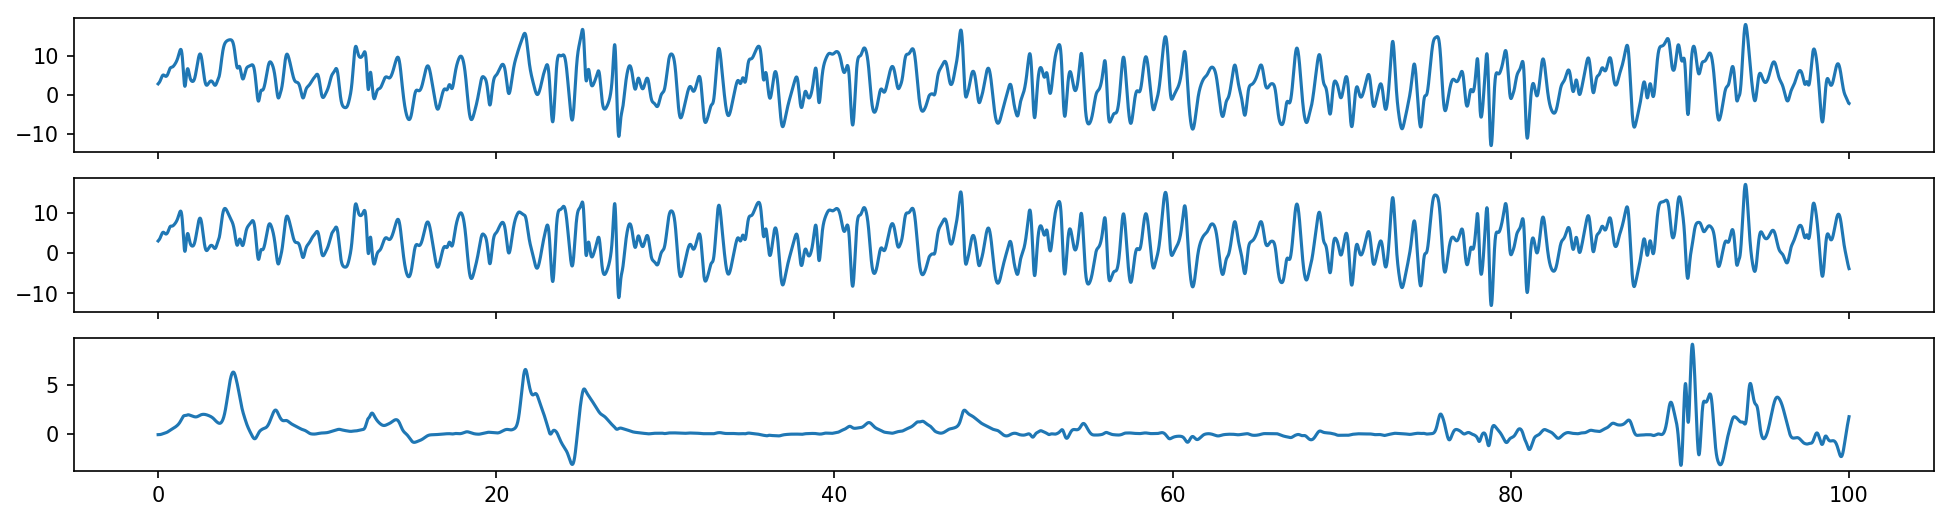

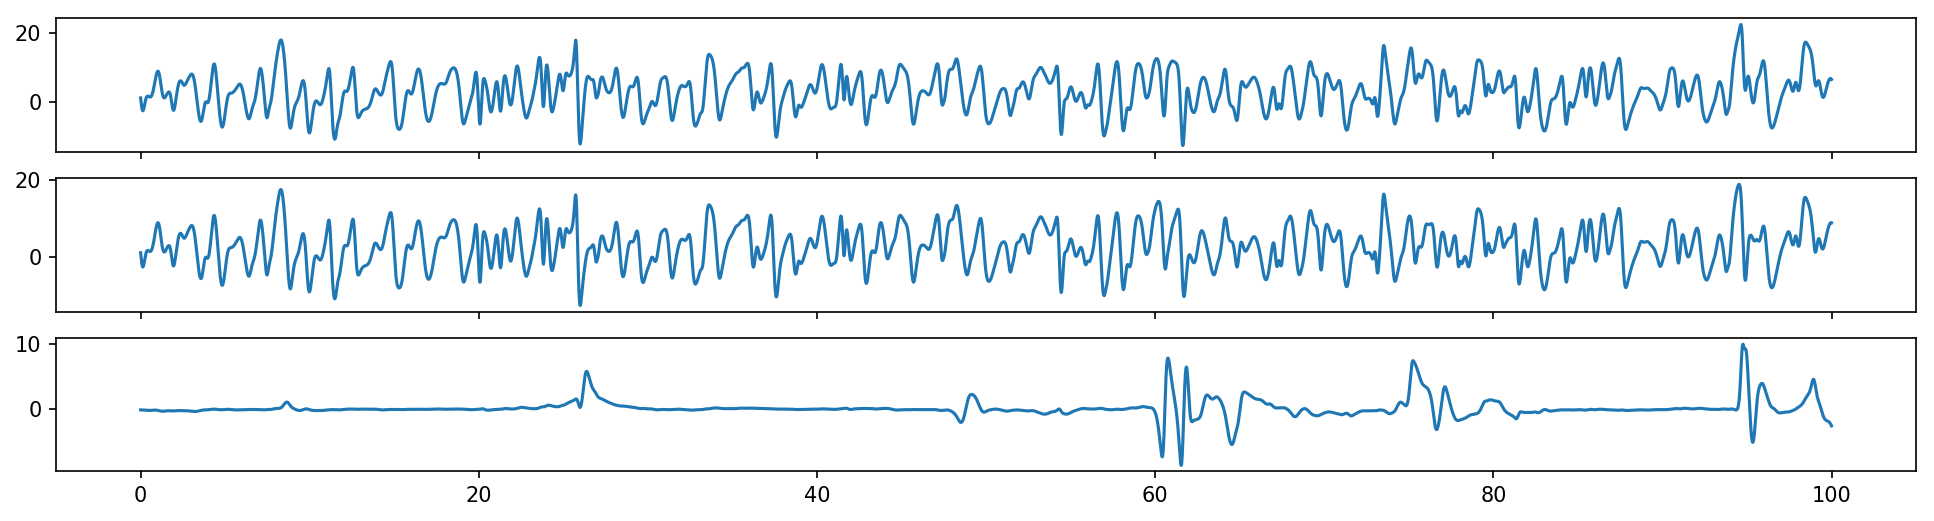

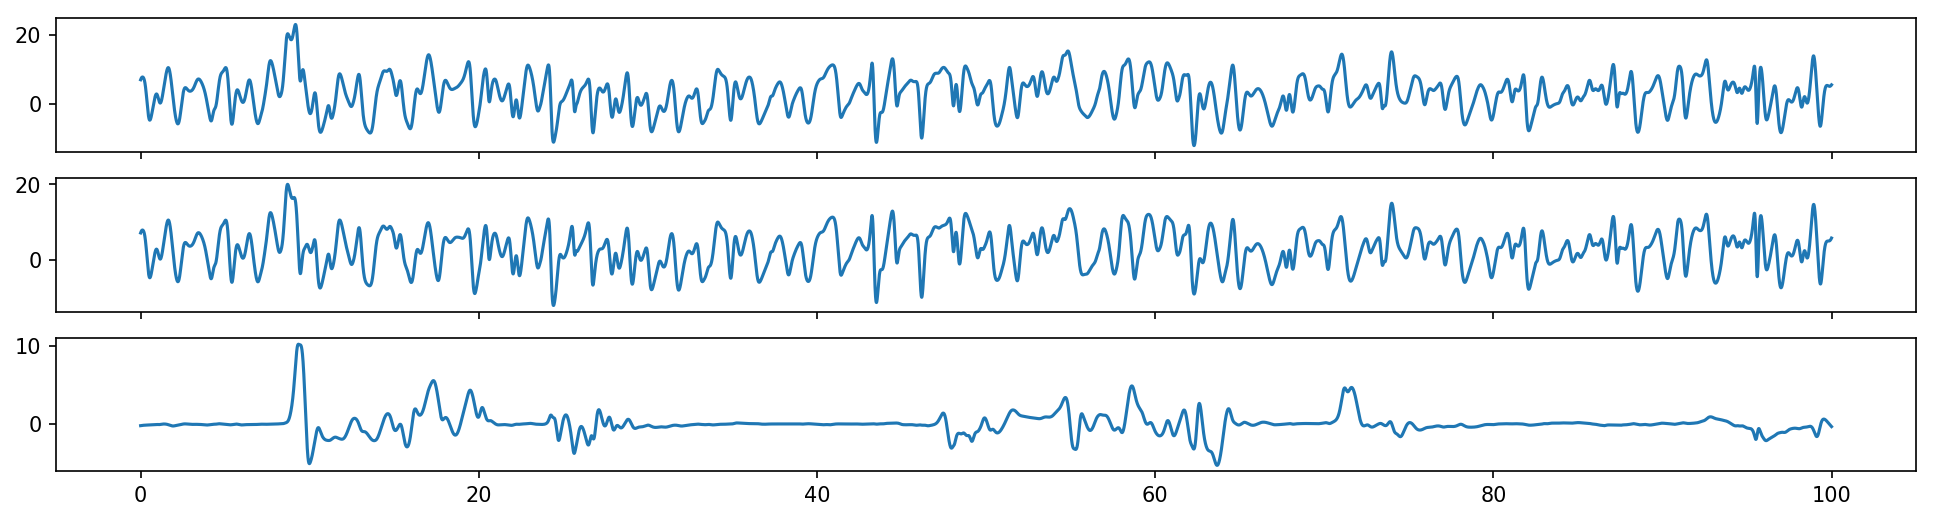

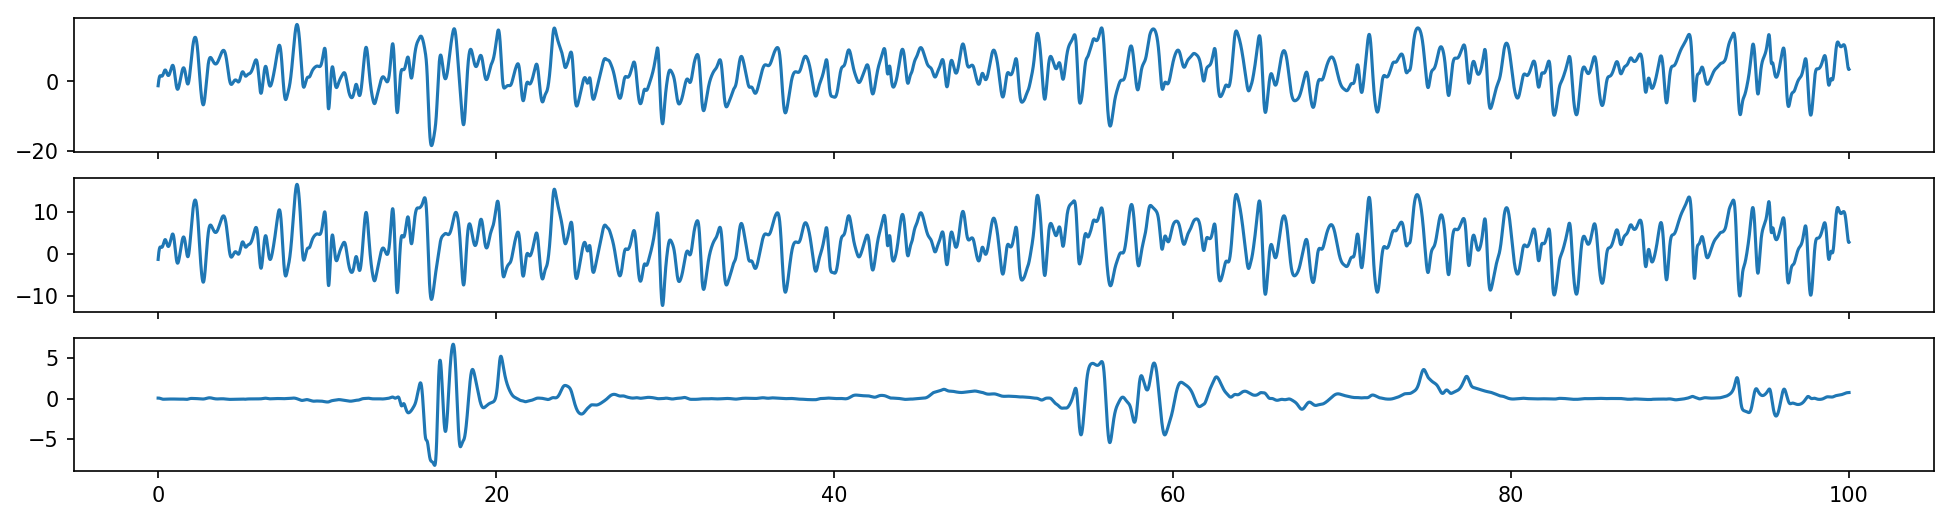

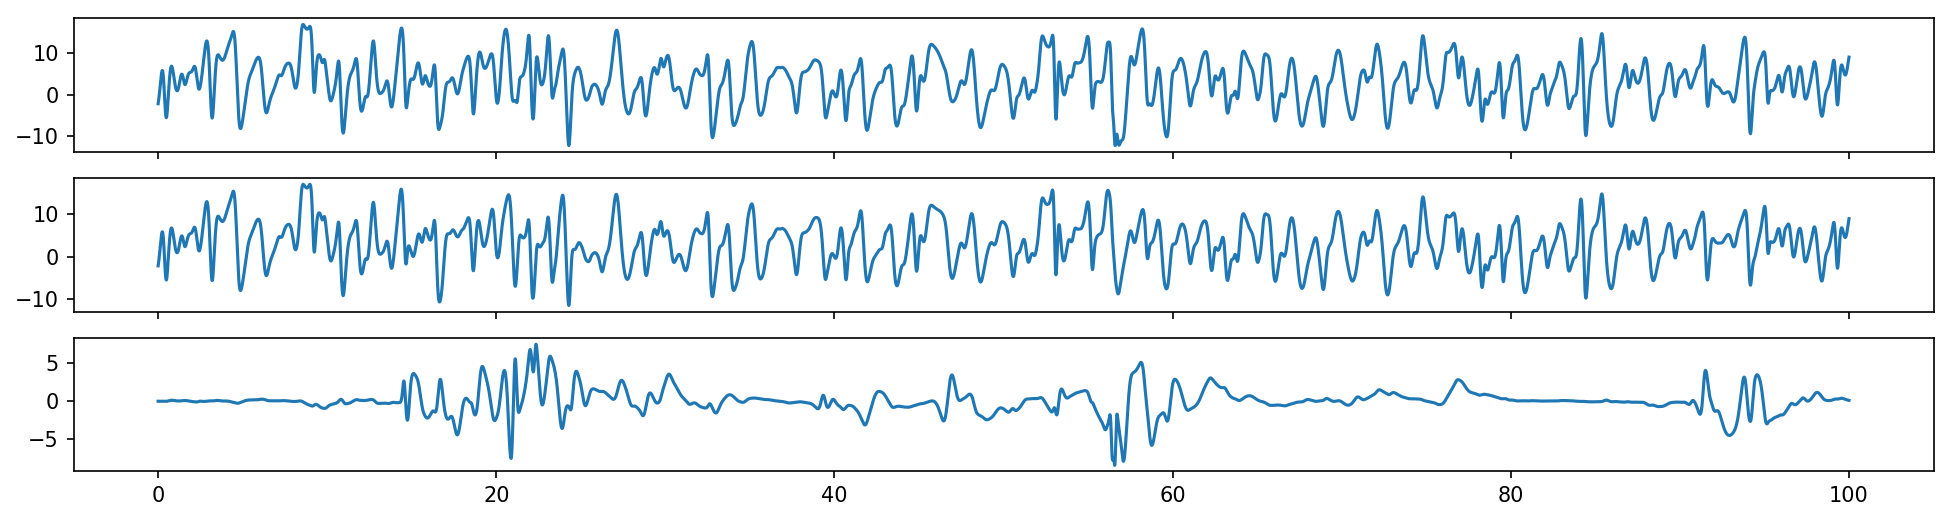

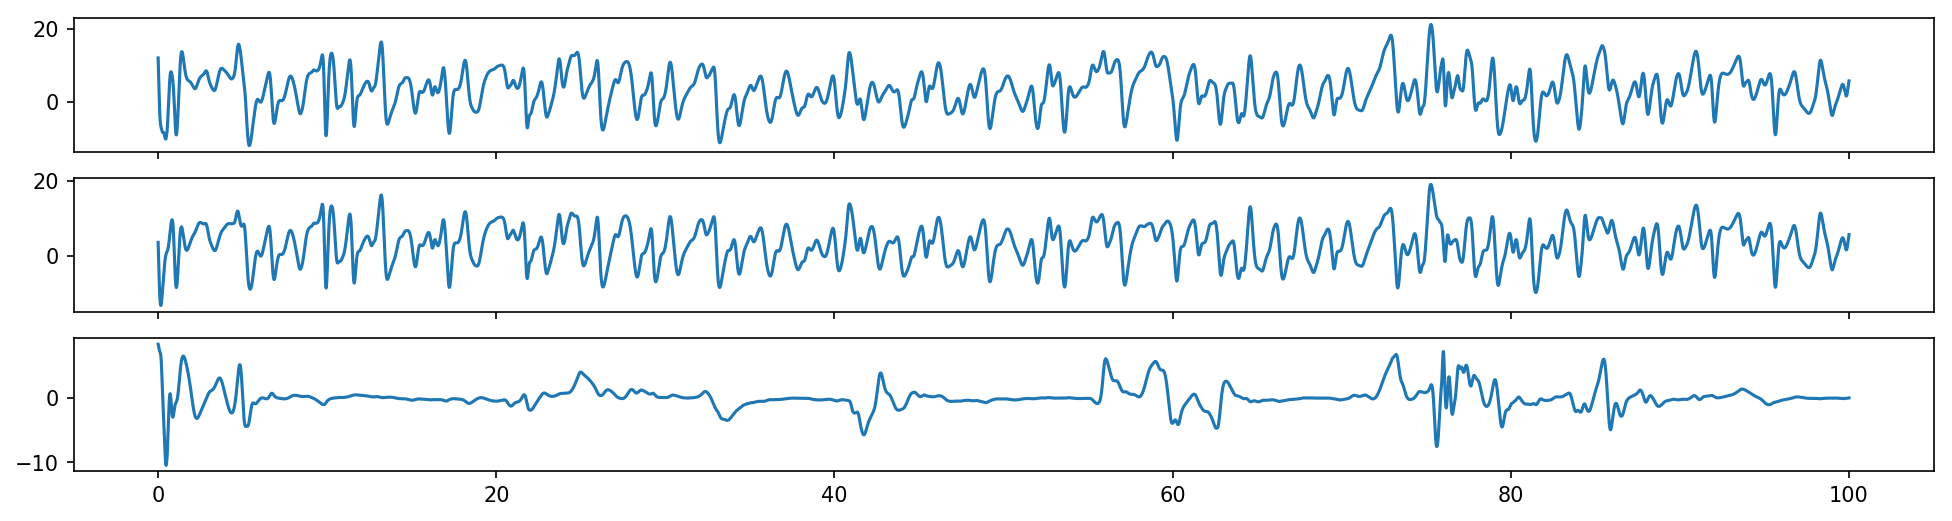

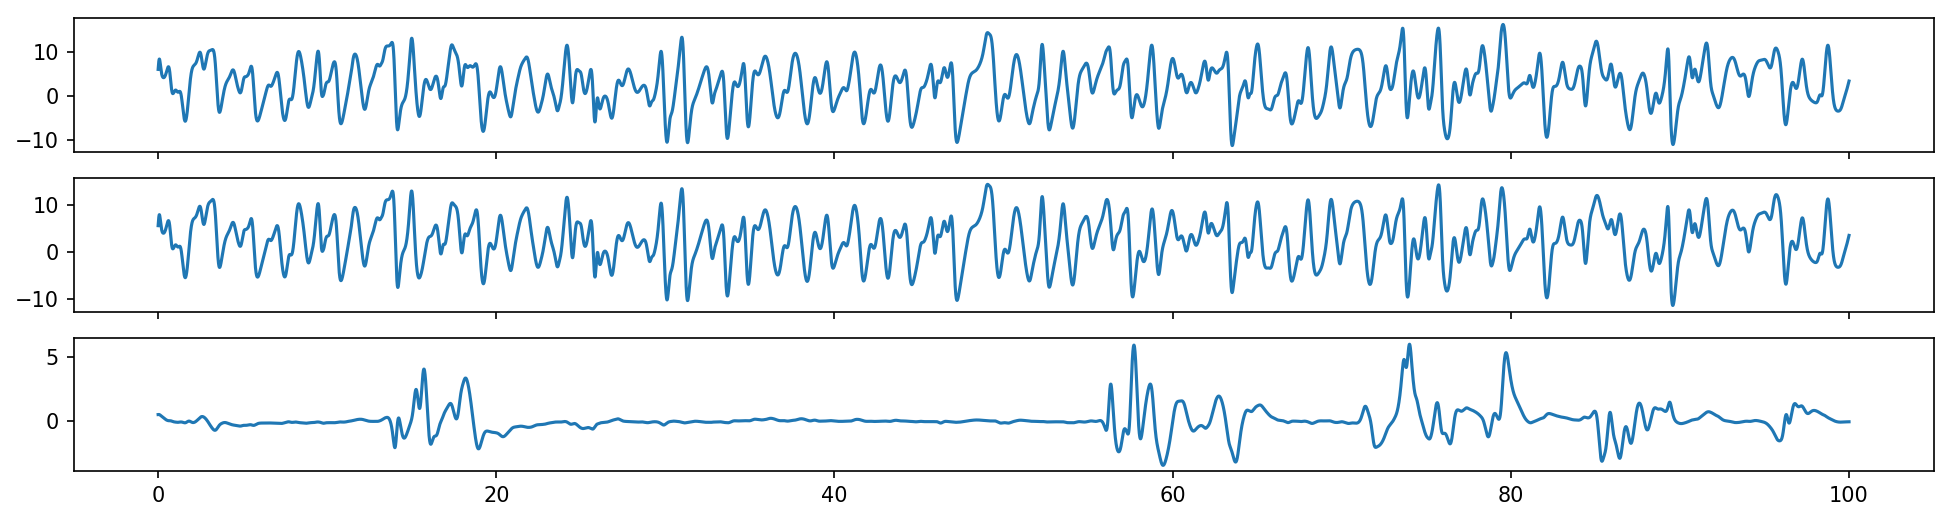

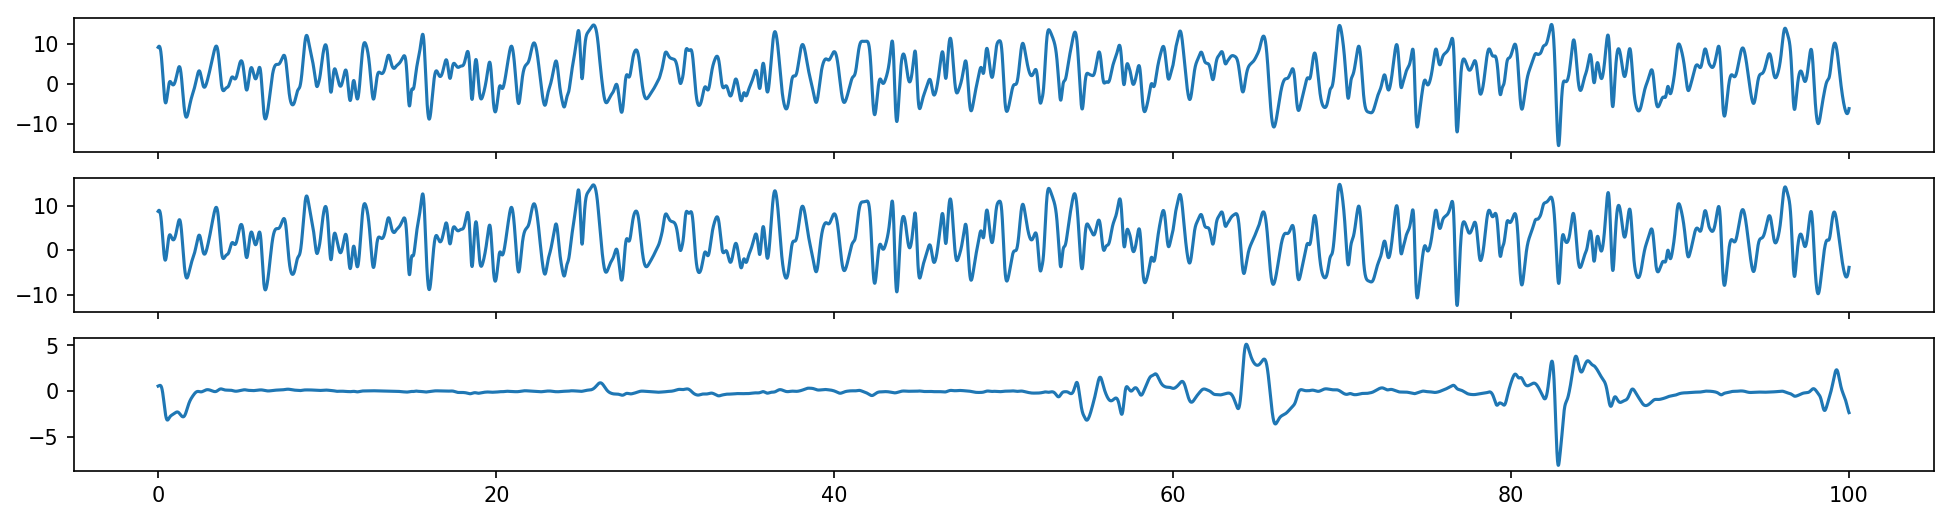

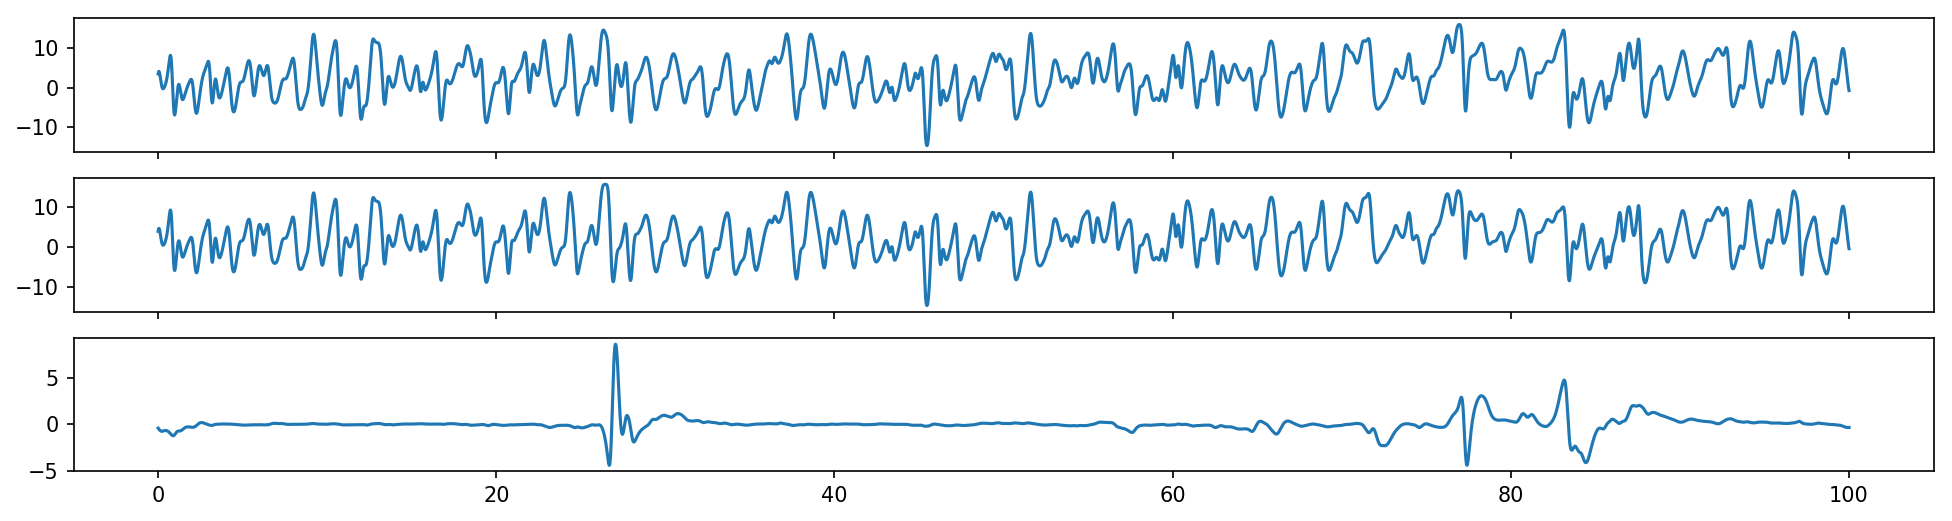

In [27]:
figsize = plt.figaspect(1/4)
dpi = 150
Tmax = 100
plot_t = Zgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax)).time
for this_loc in range(9):
    this_loc *= 100
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=figsize, dpi=dpi)
    ax[0].plot(plot_t,
               Zgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax)))
    ax[1].plot(plot_t,
               Xgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax)))
    ax[2].plot(plot_t,
               Ygt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax)))


In [ ]:
plt.legend

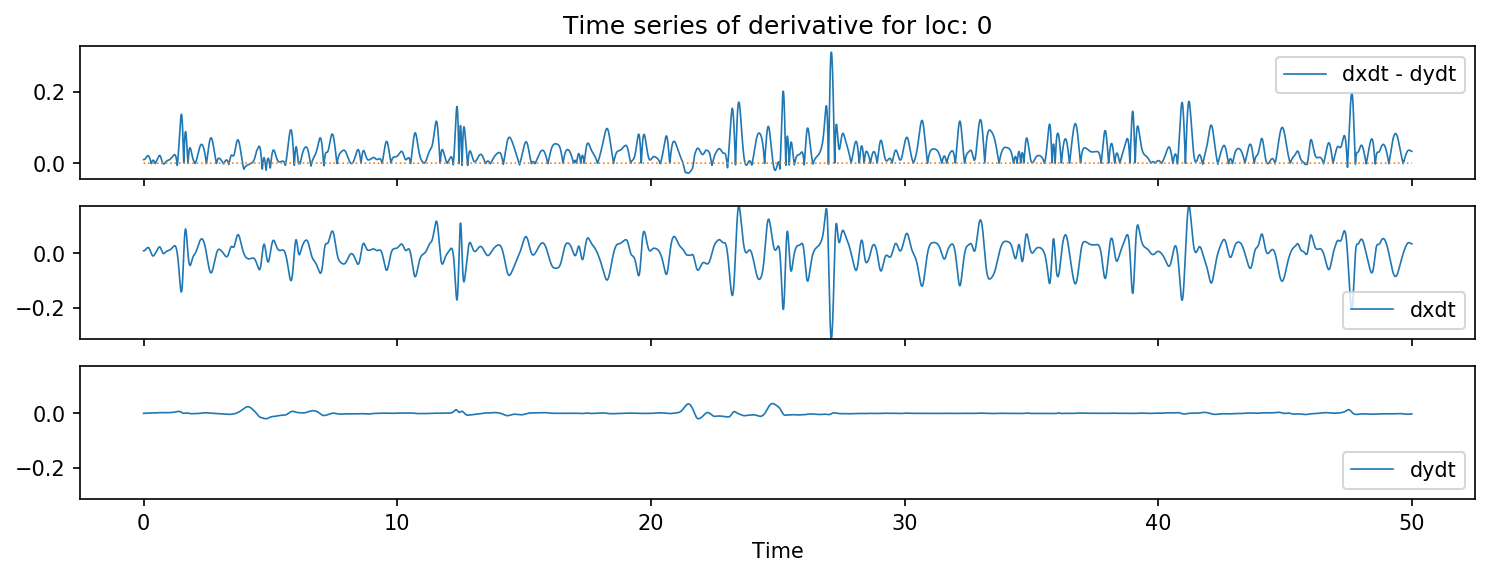

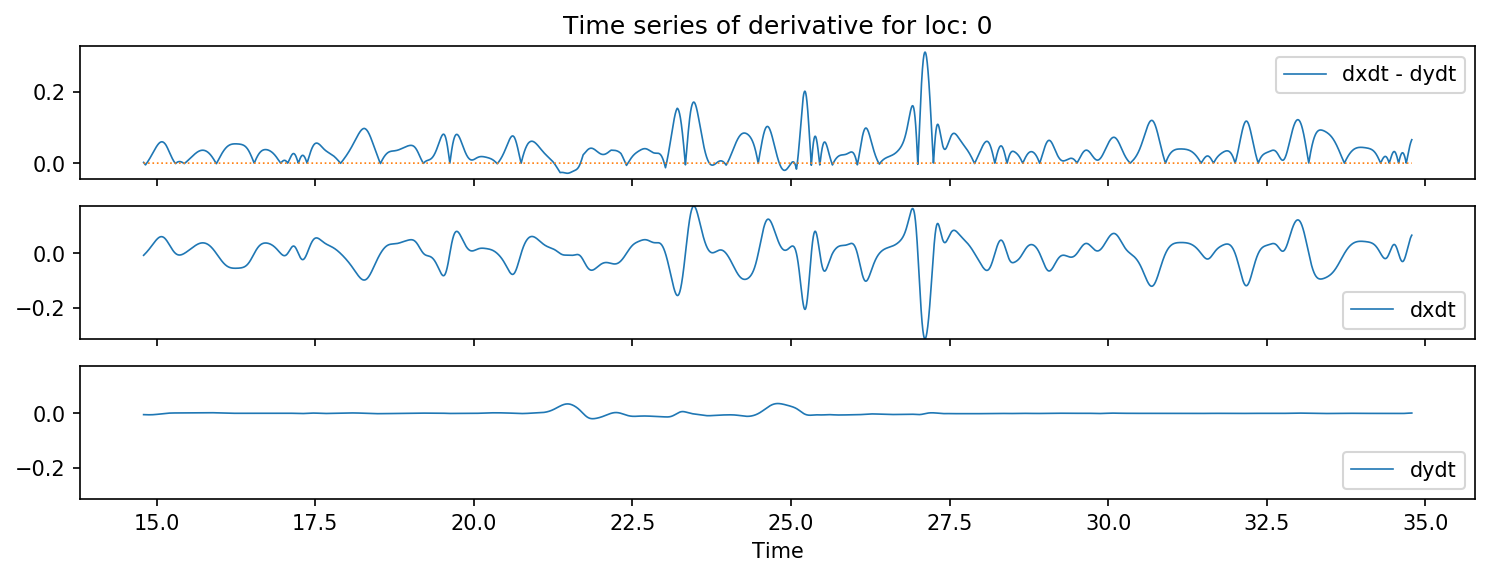

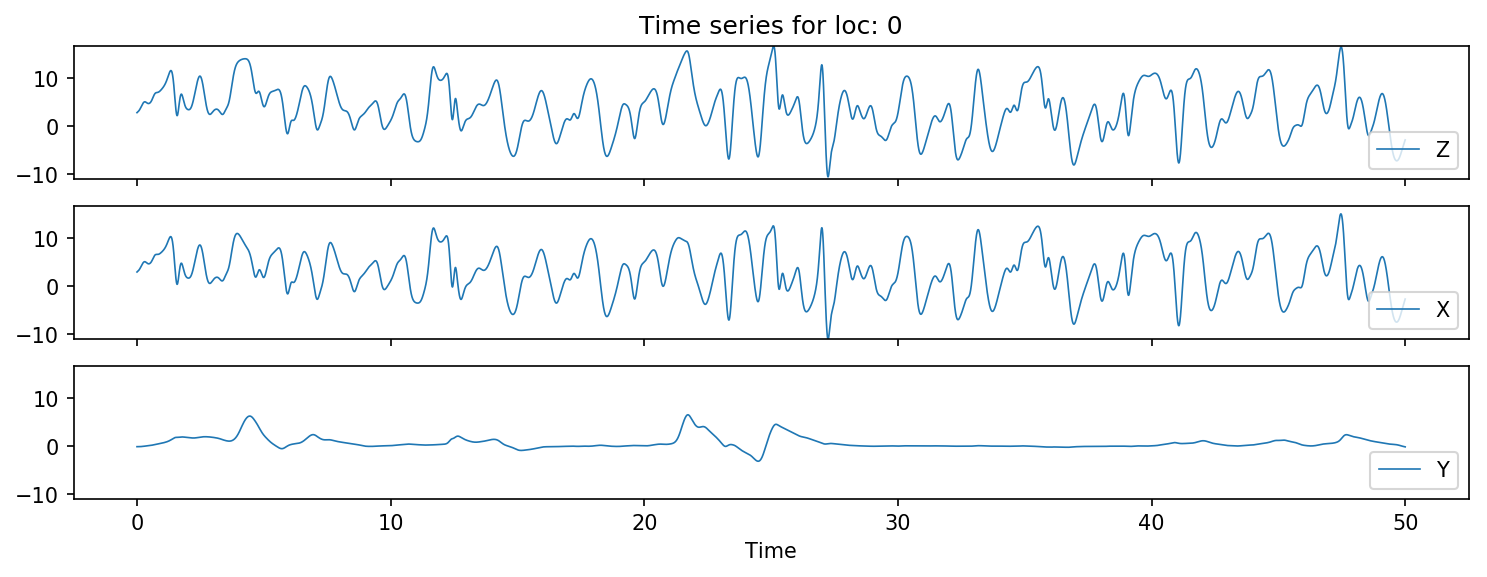

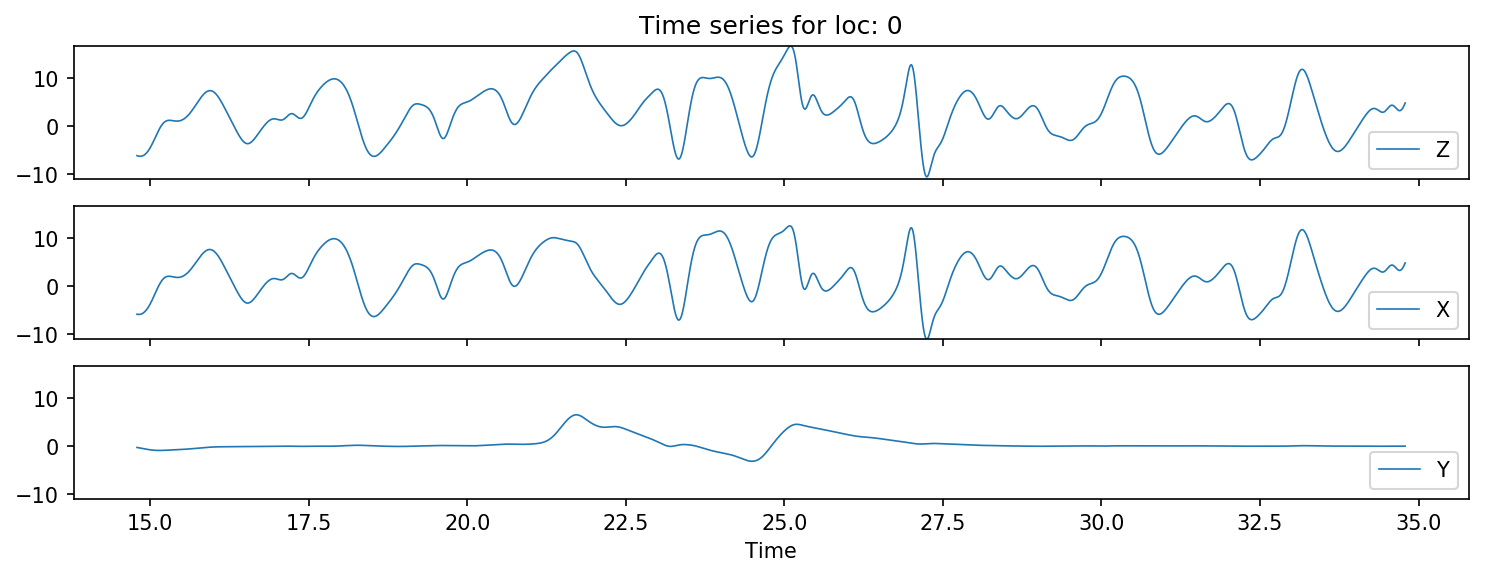

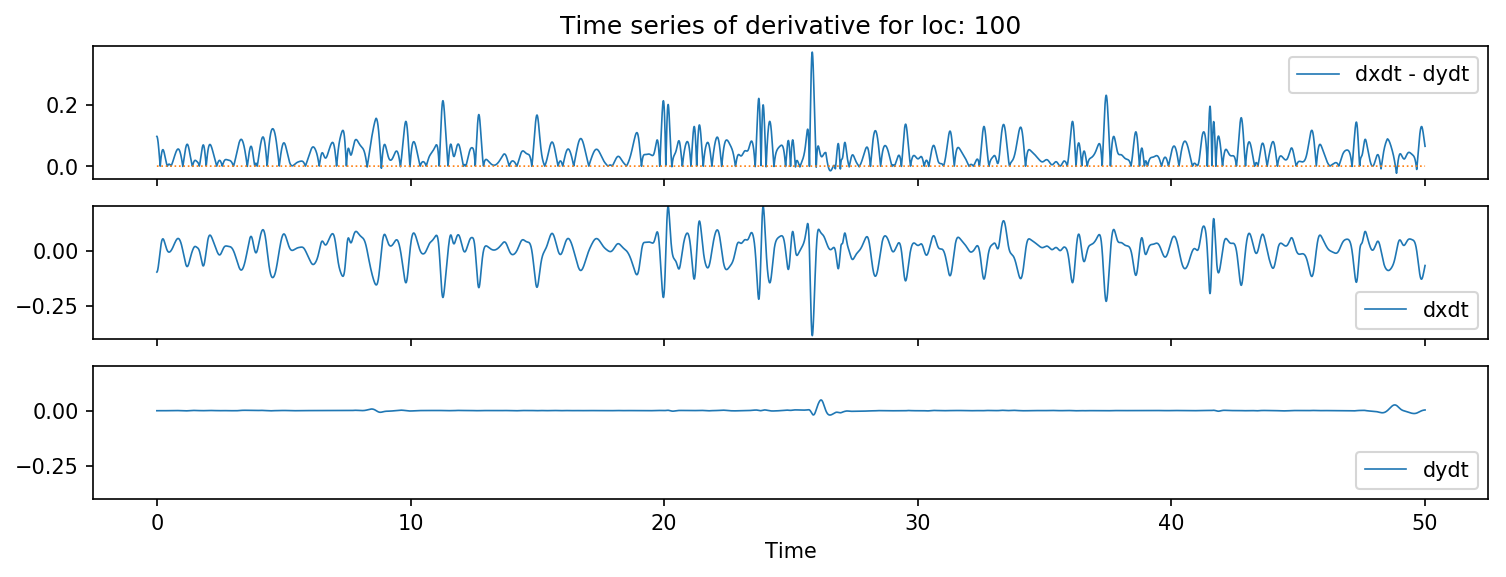

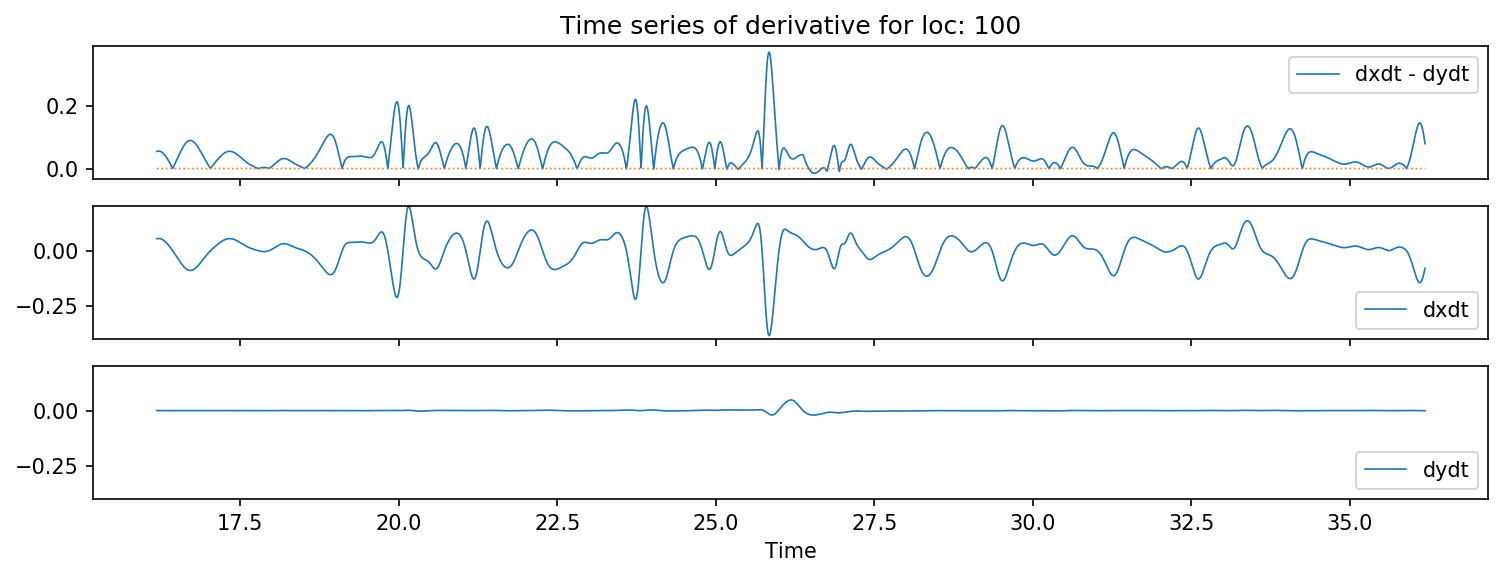

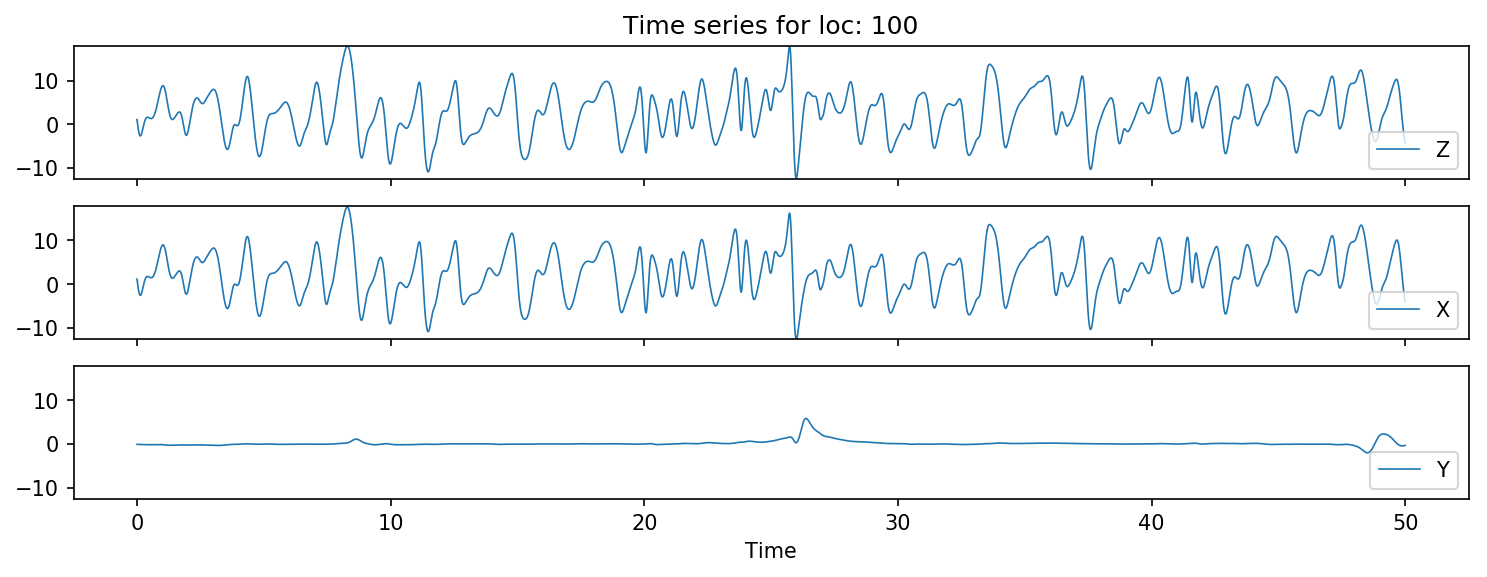

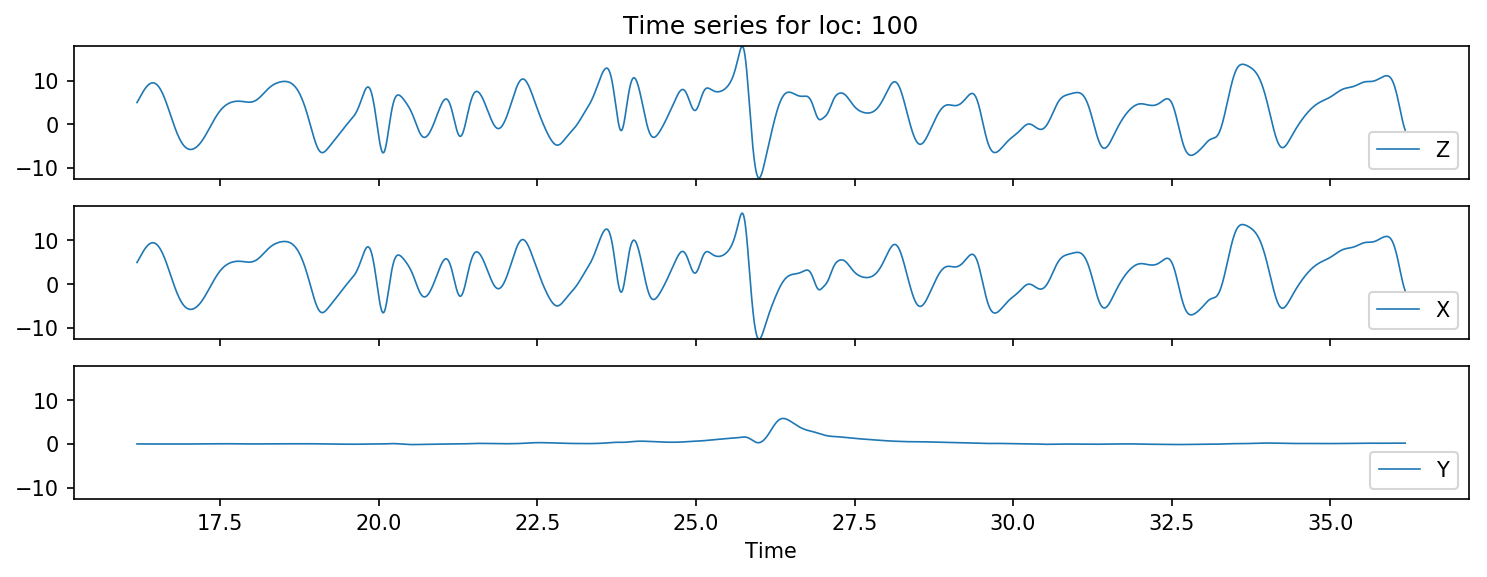

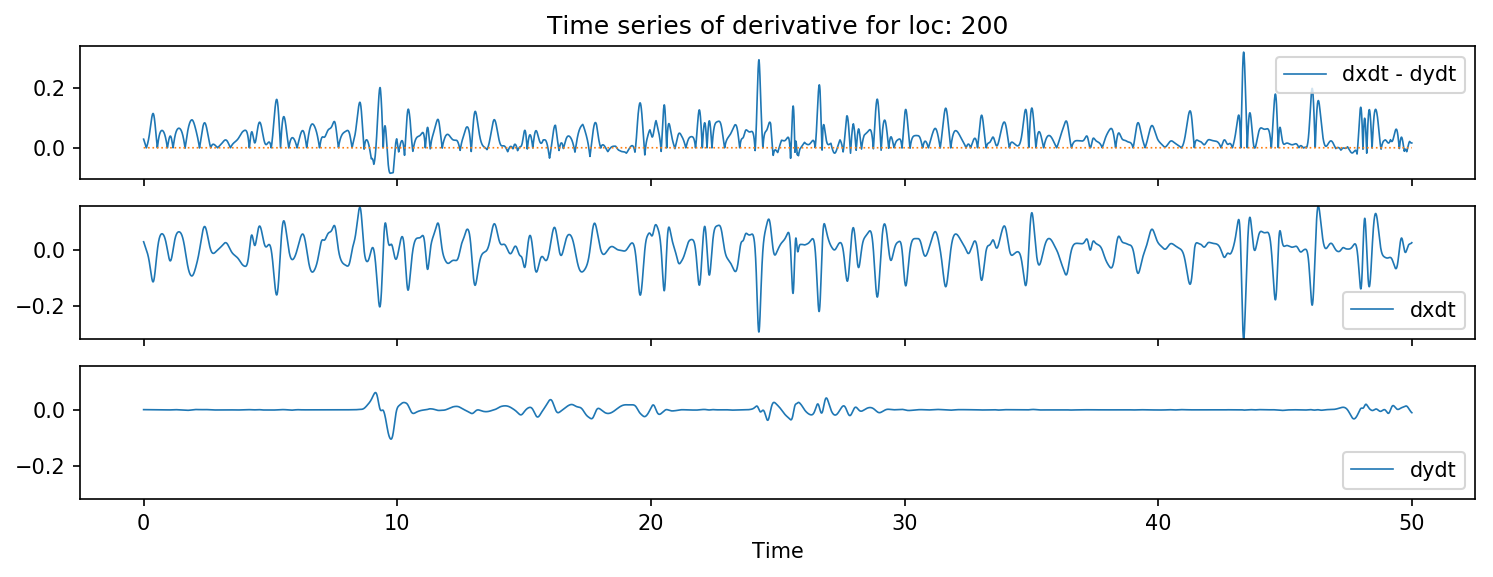

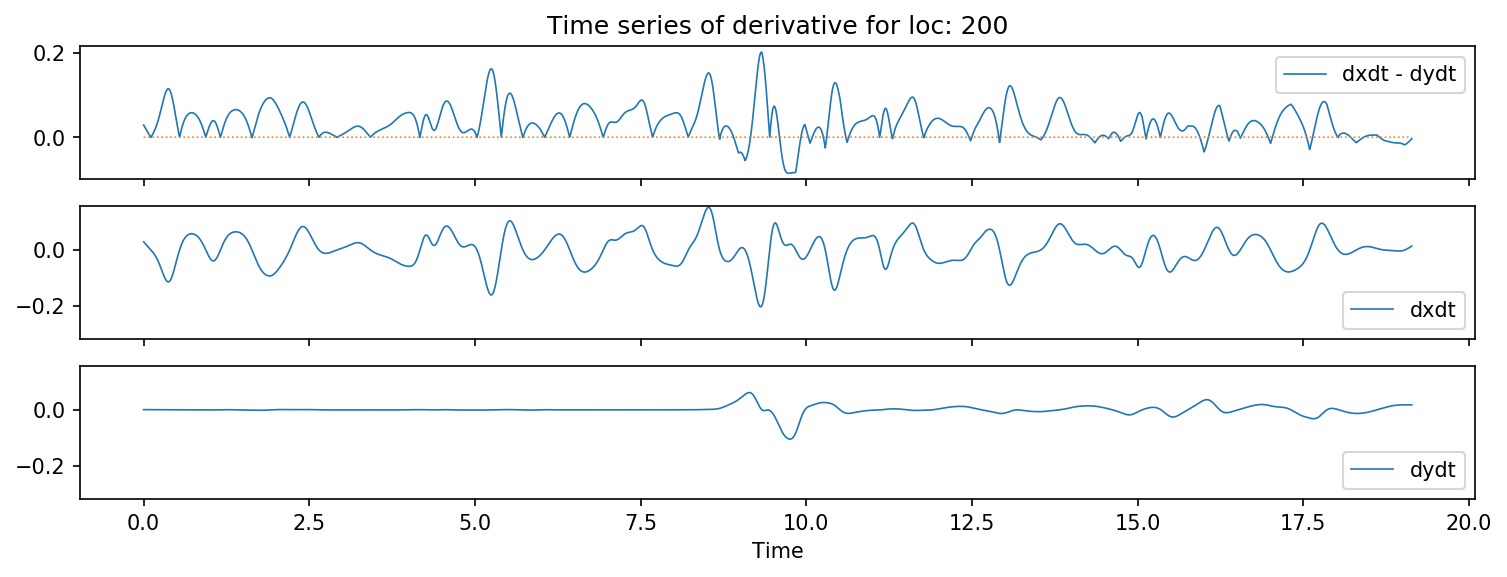

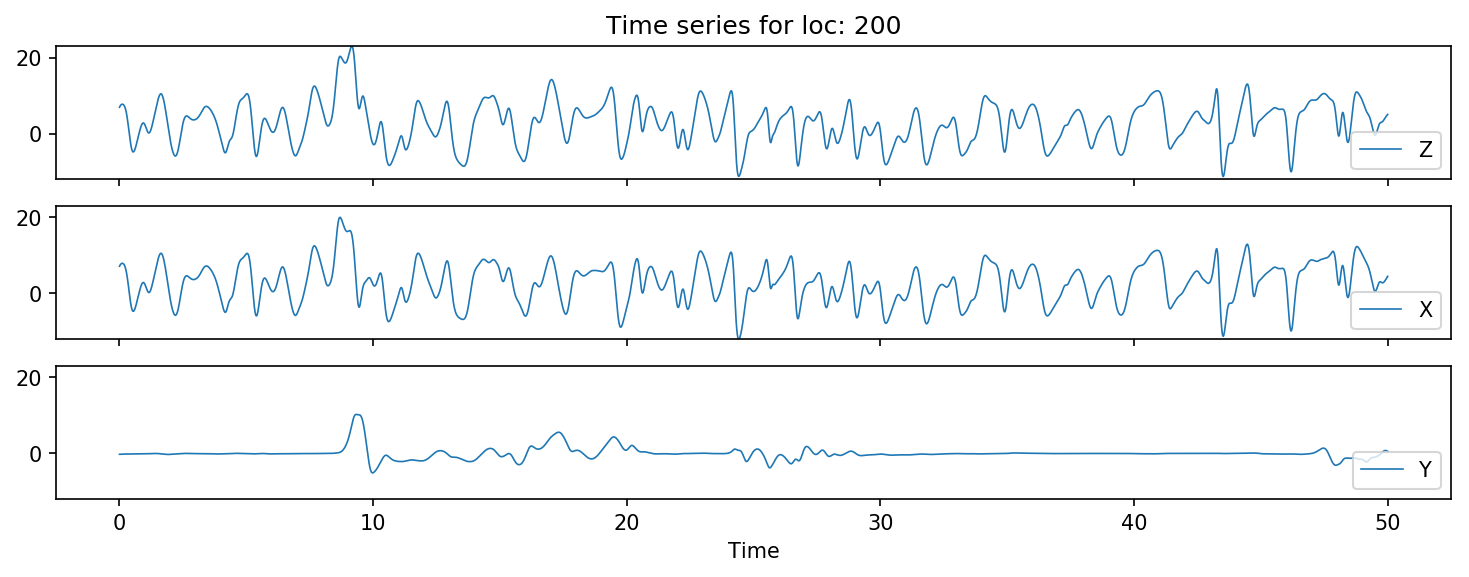

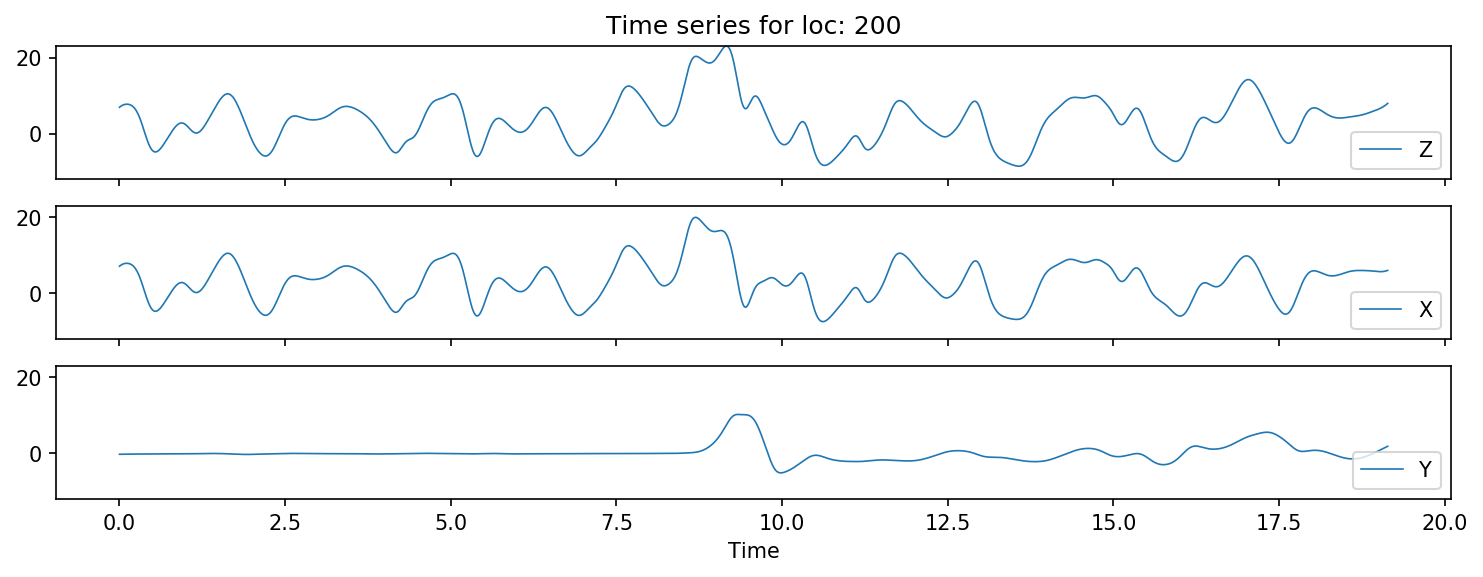

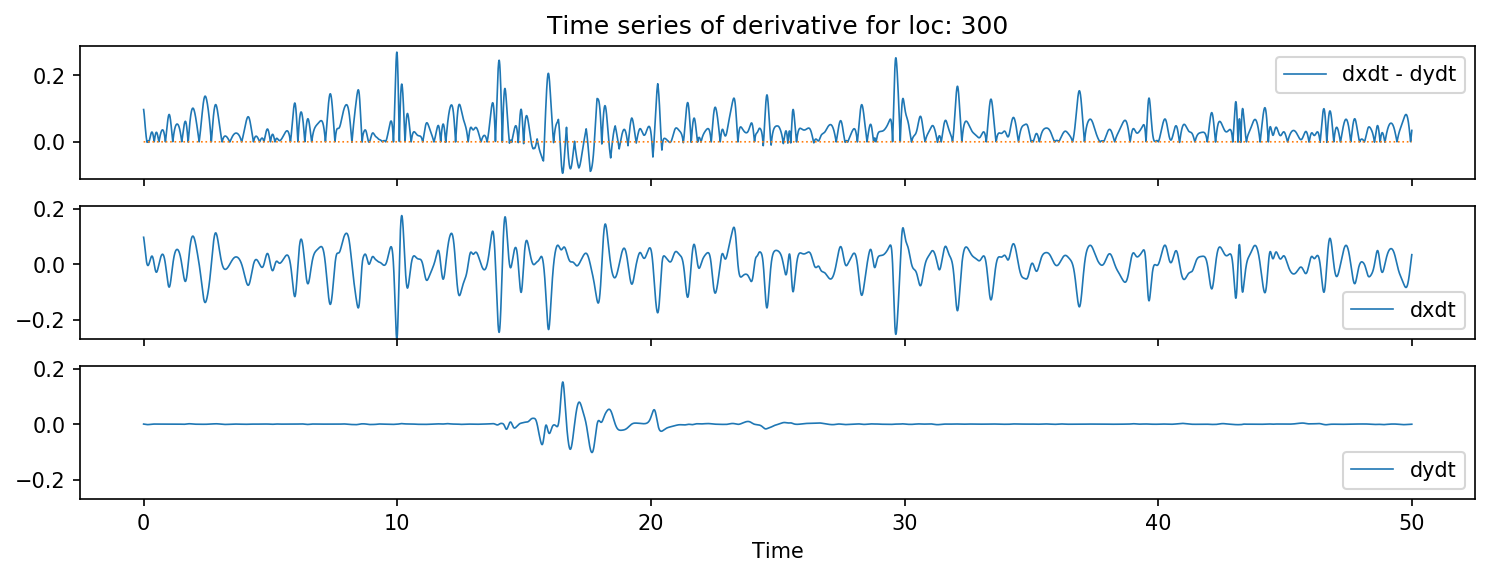

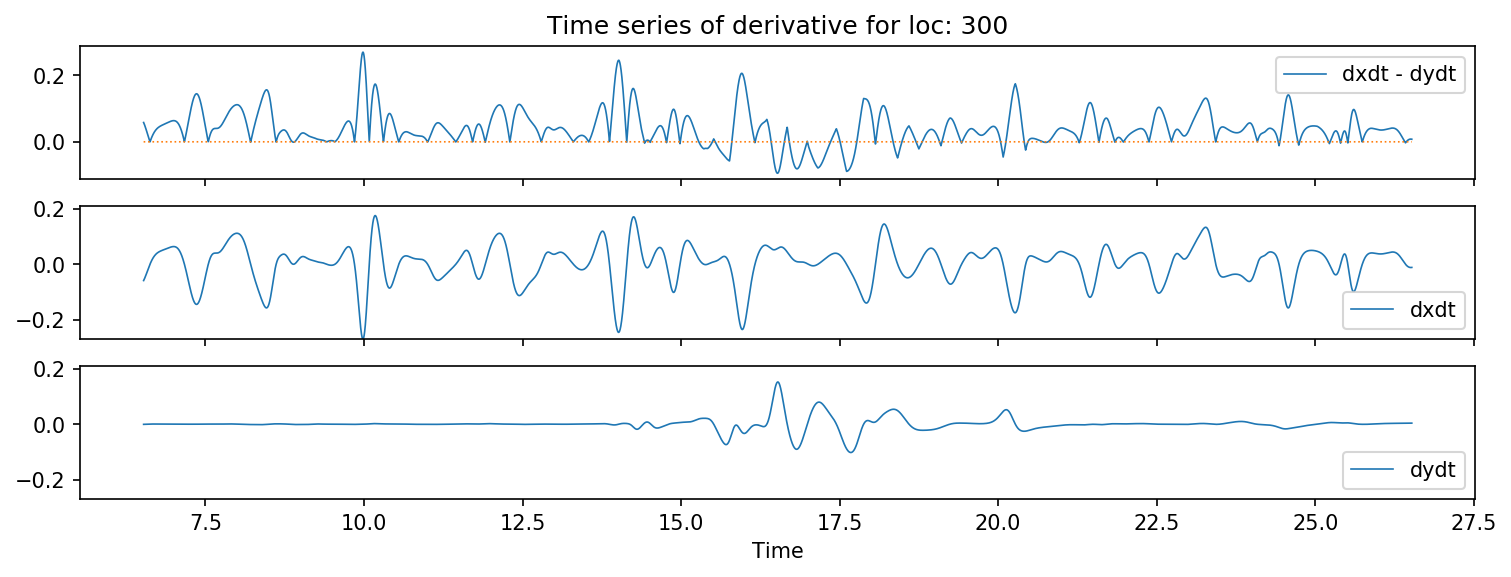

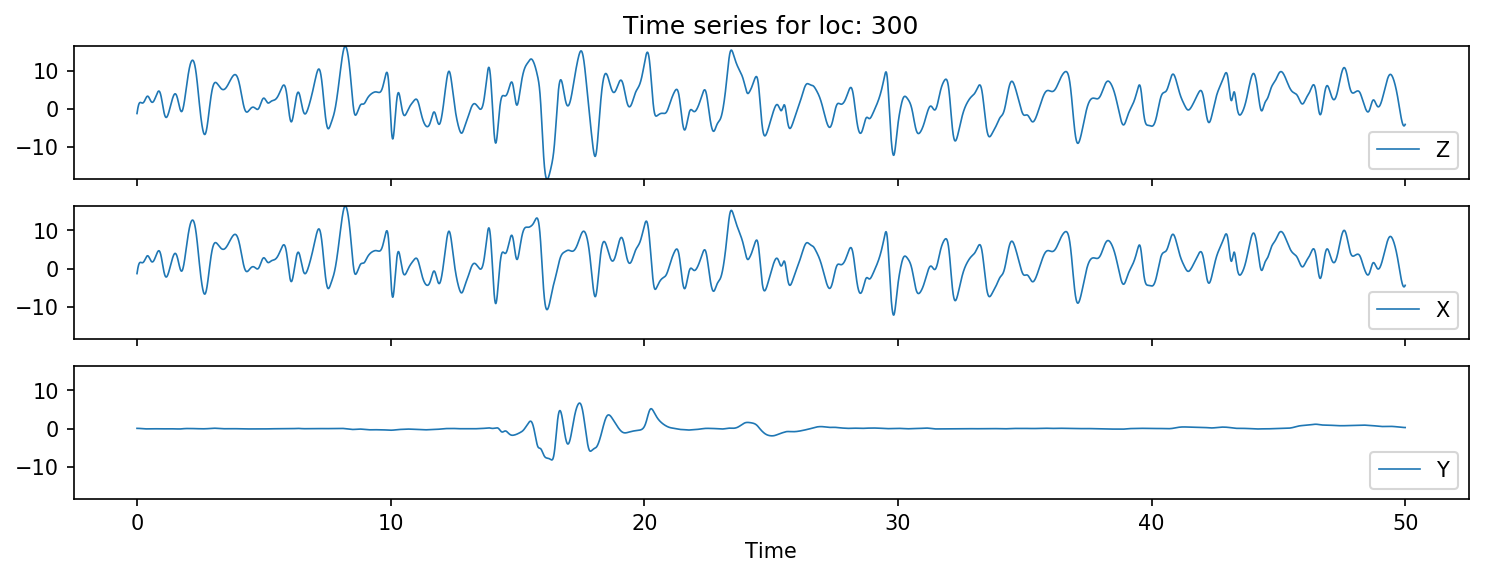

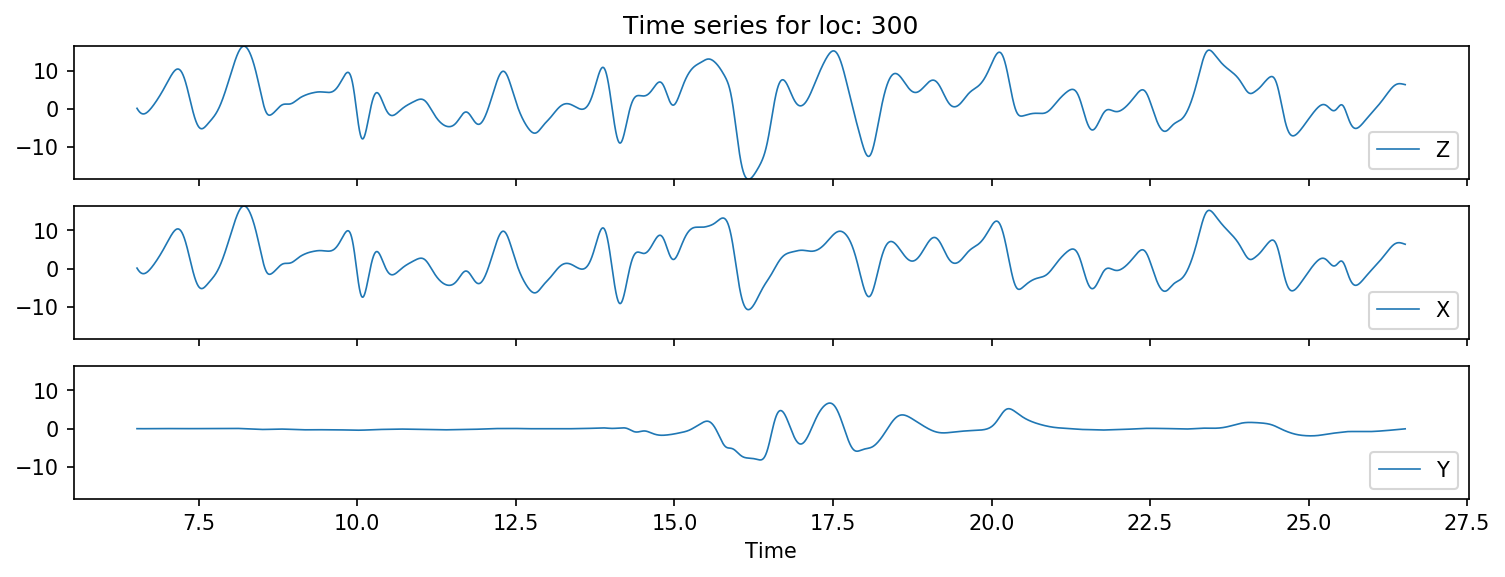

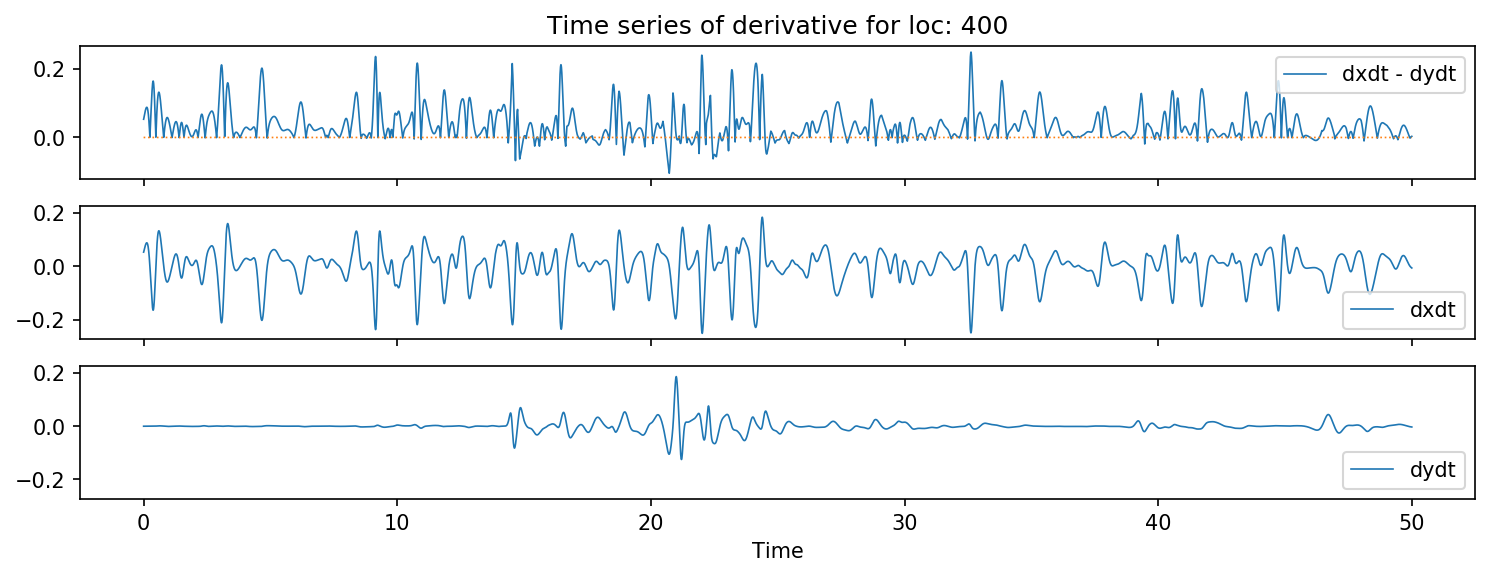

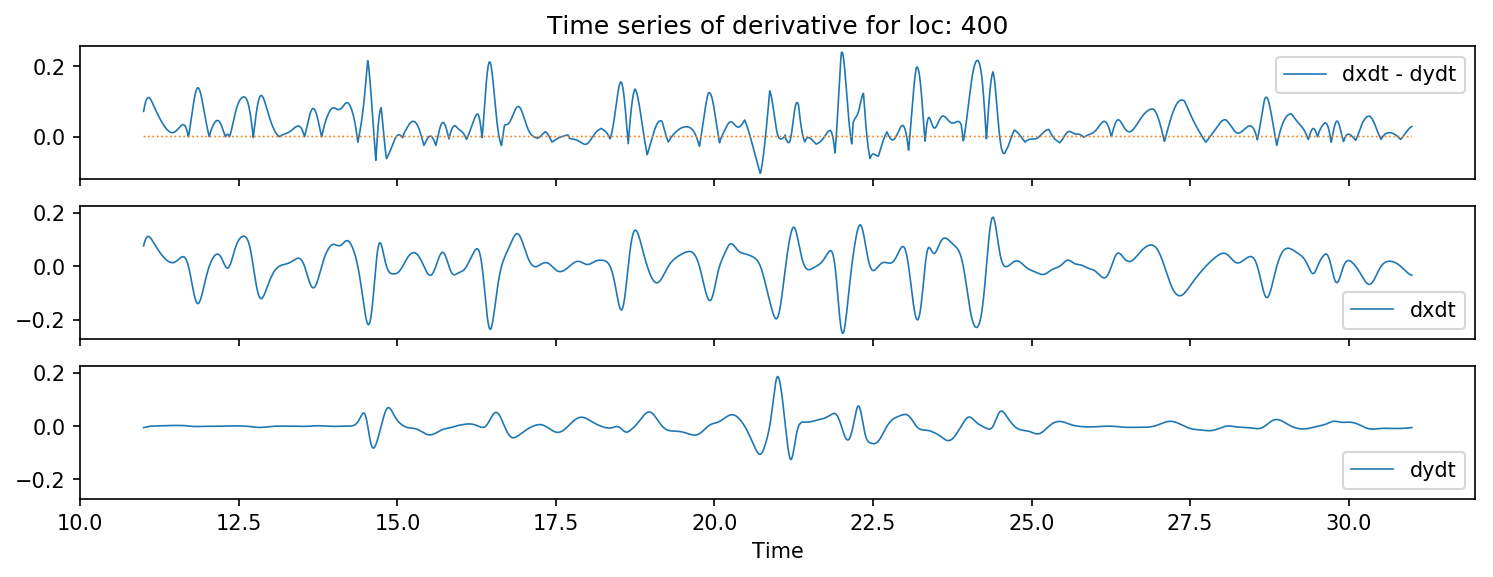

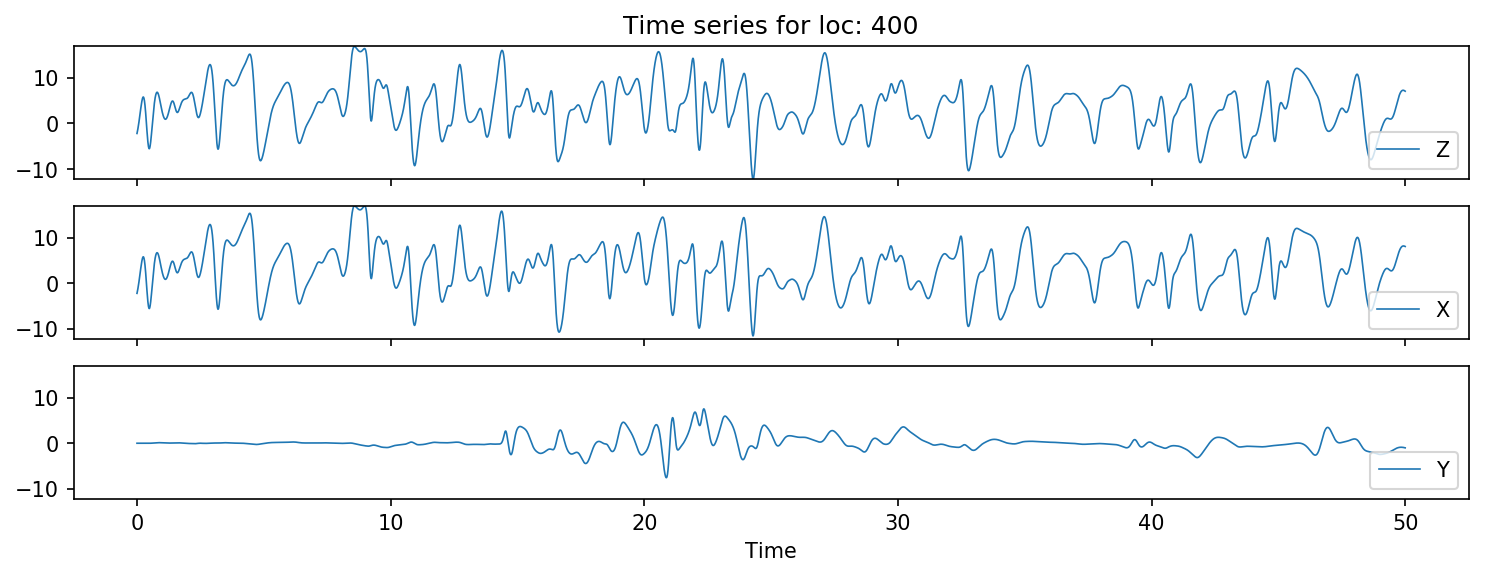

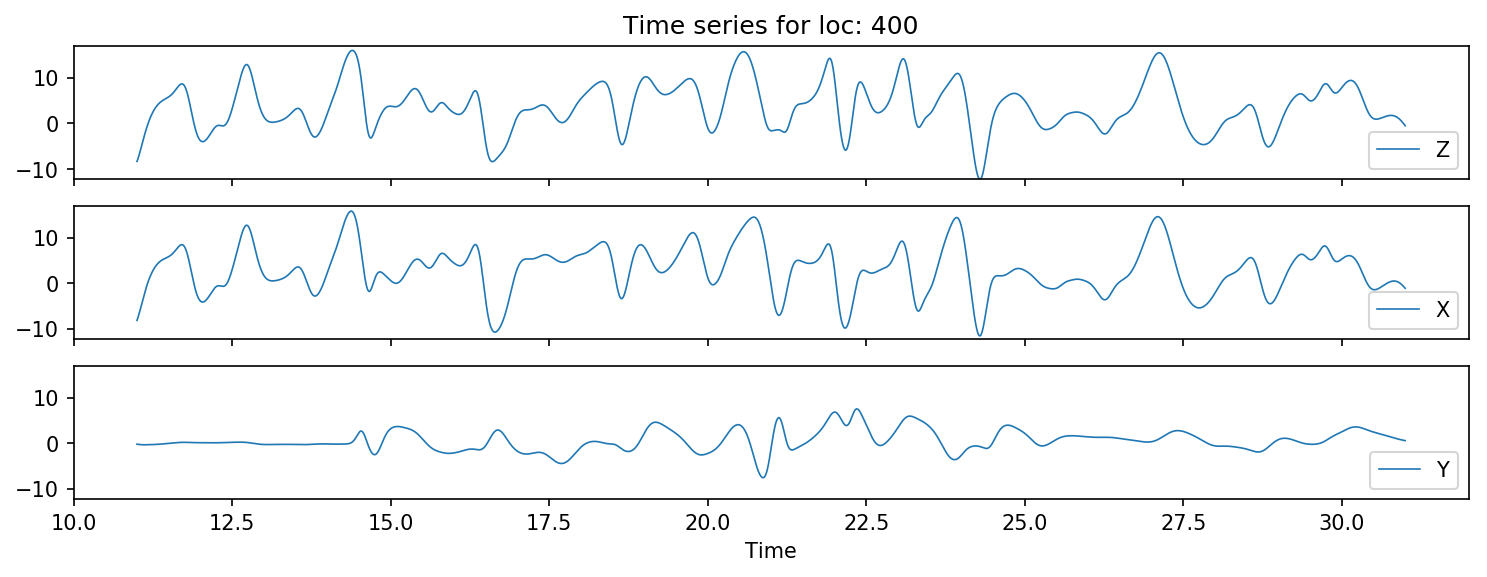

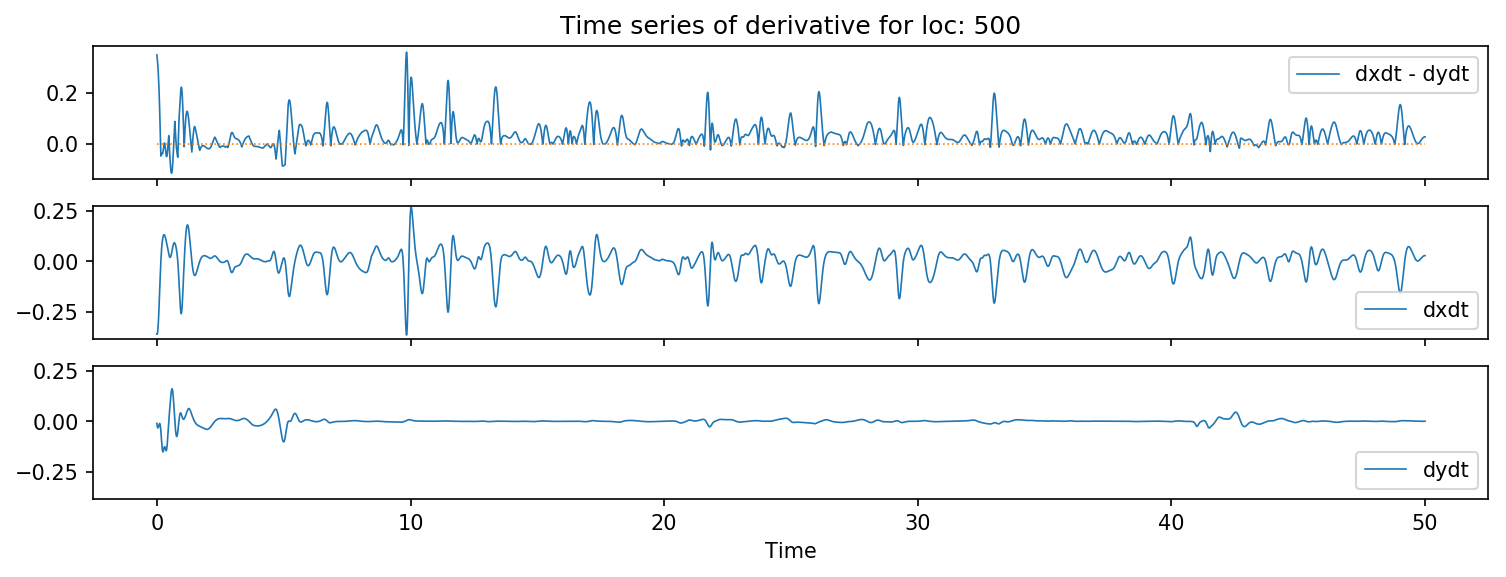

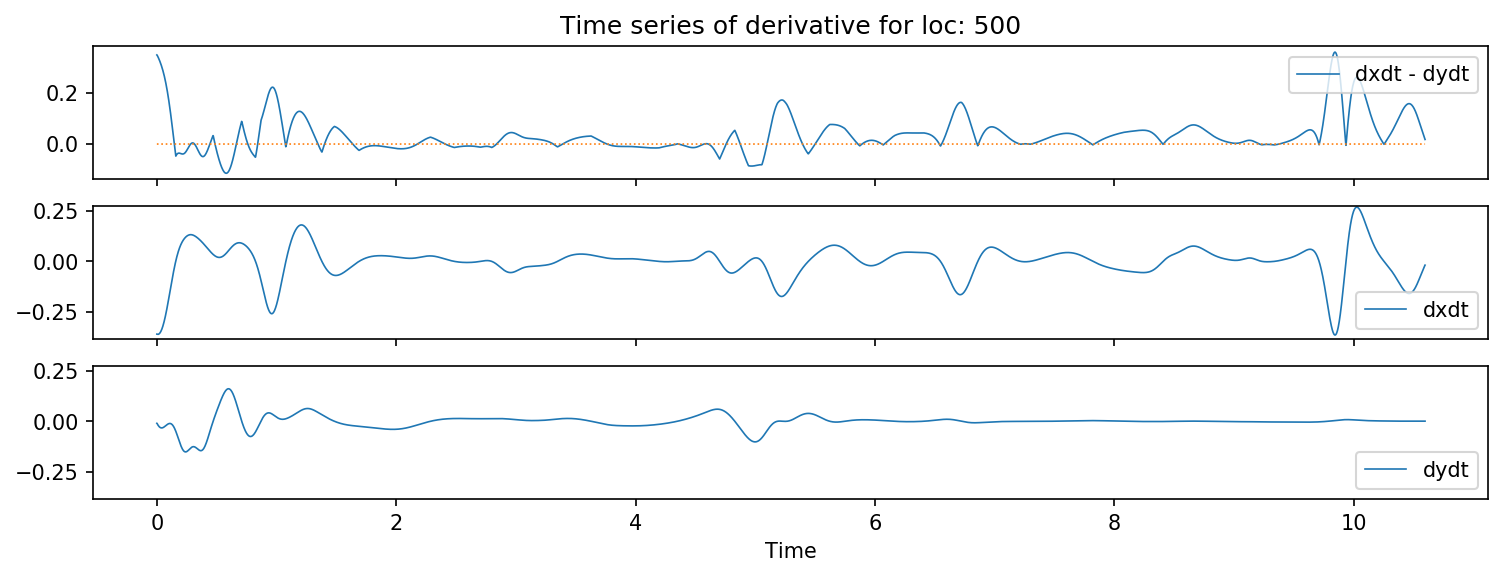

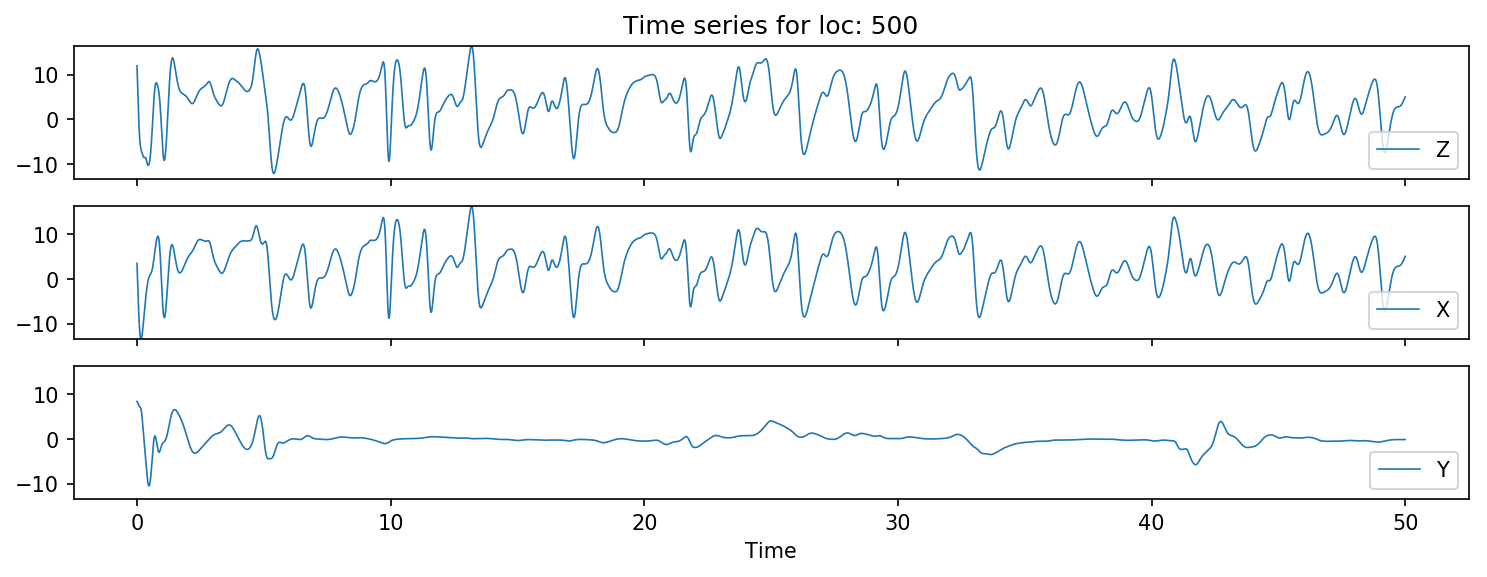

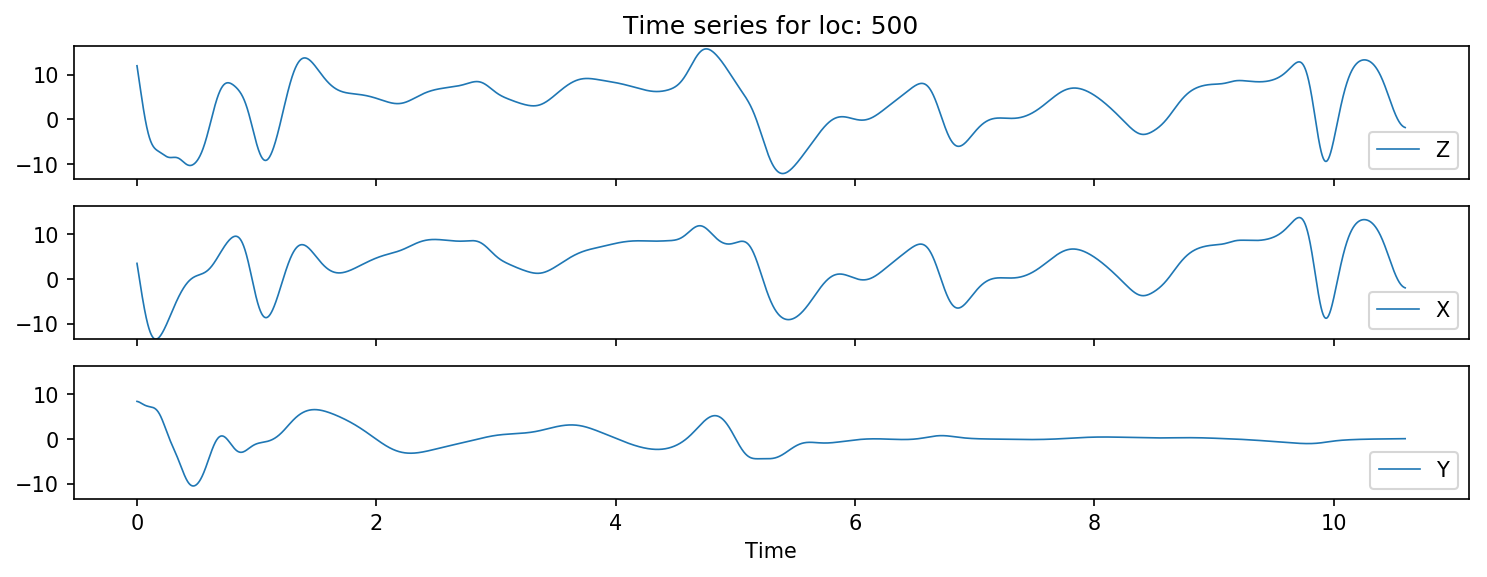

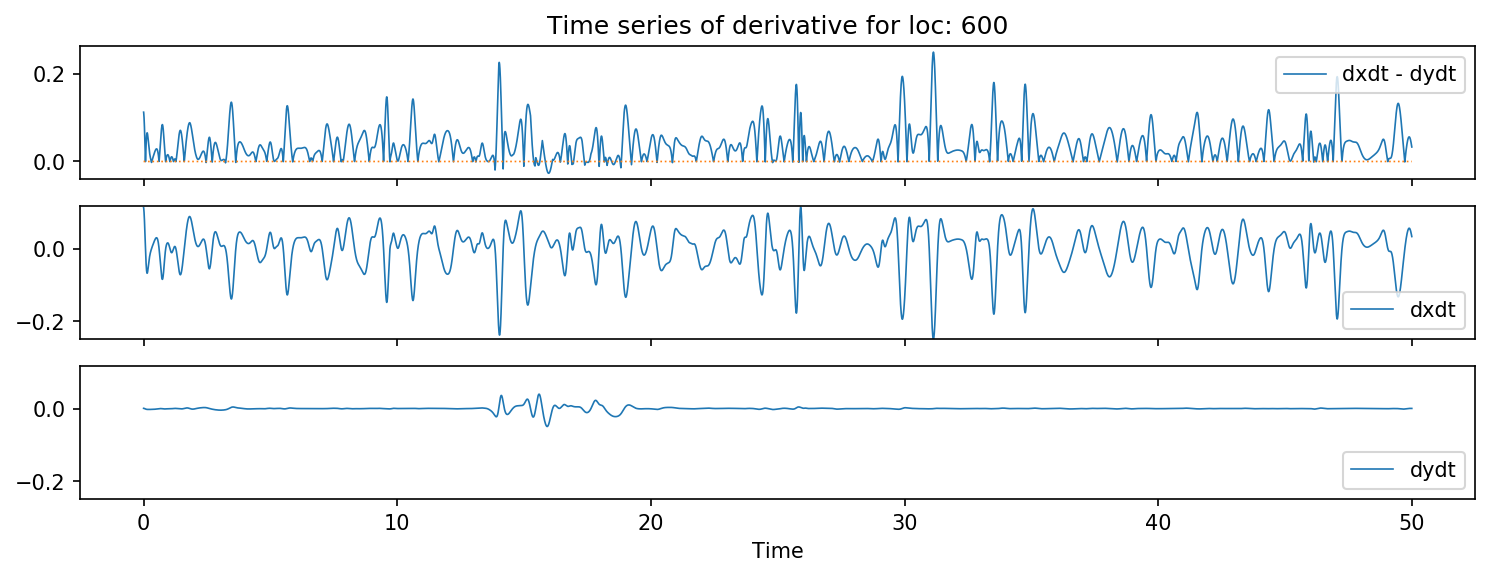

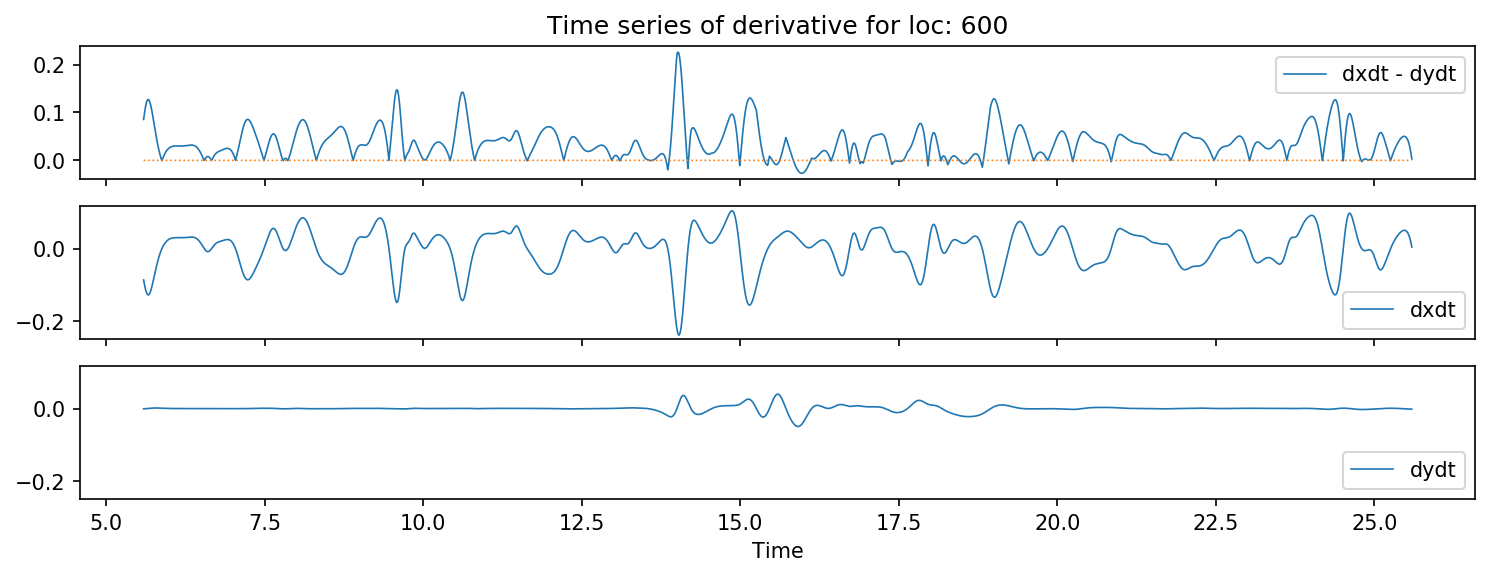

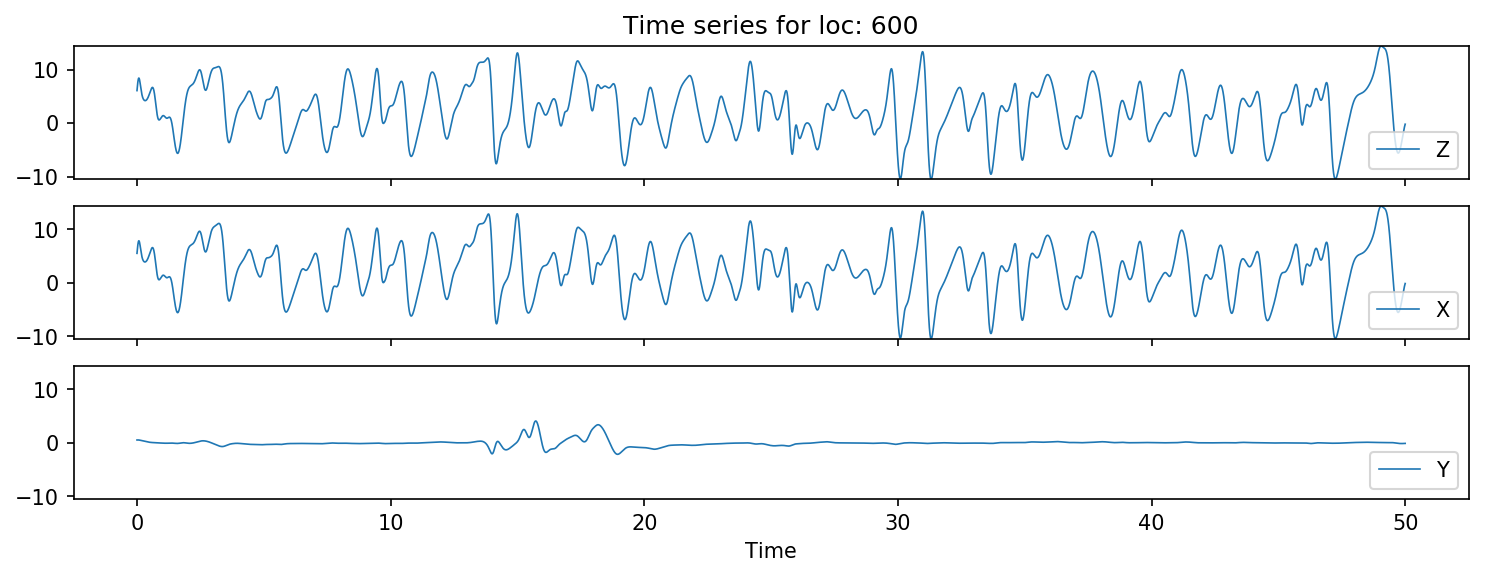

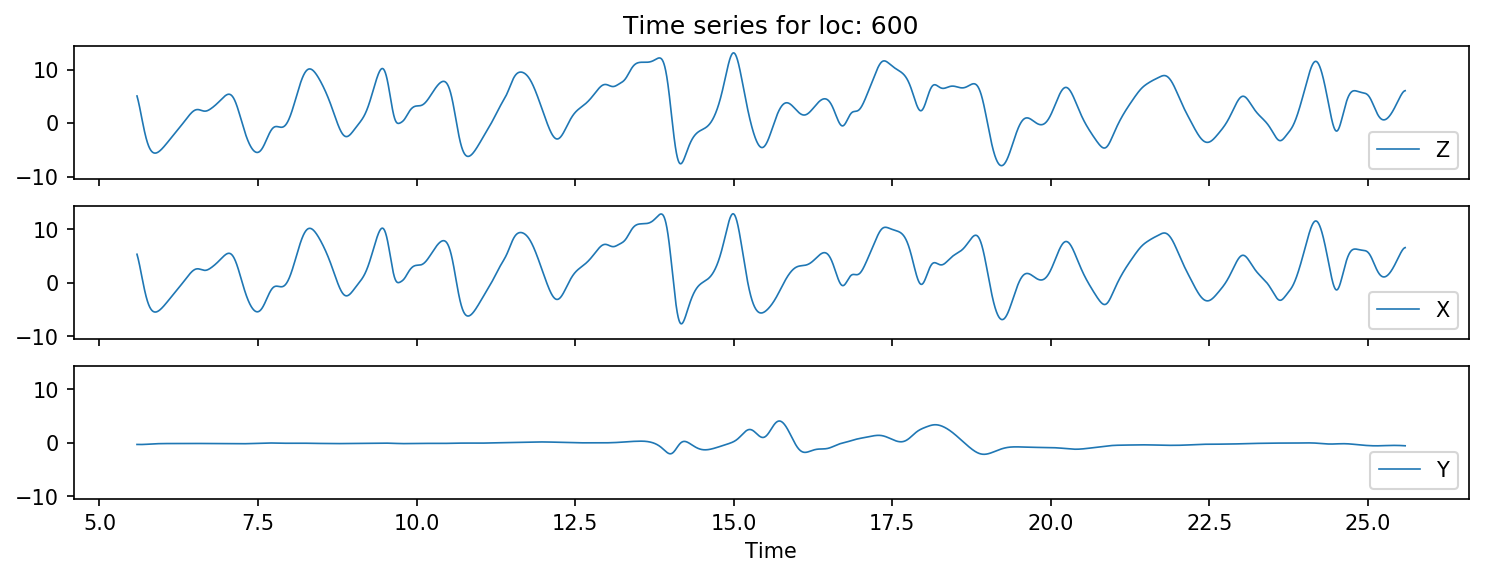

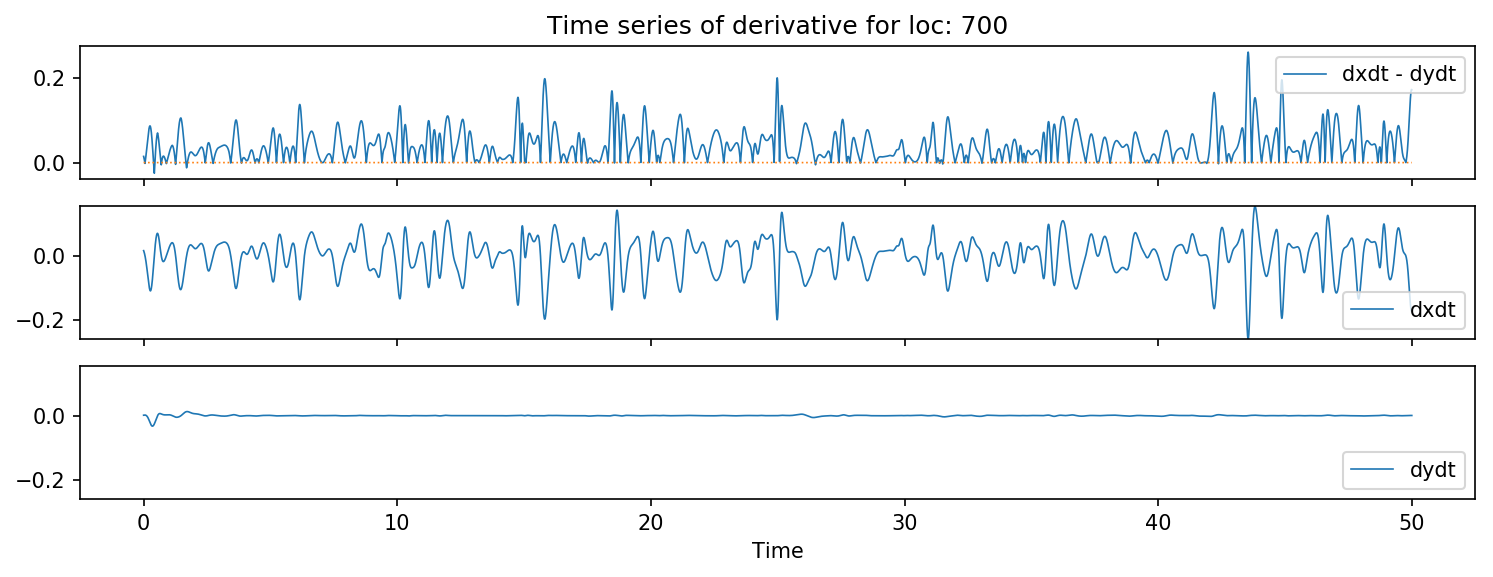

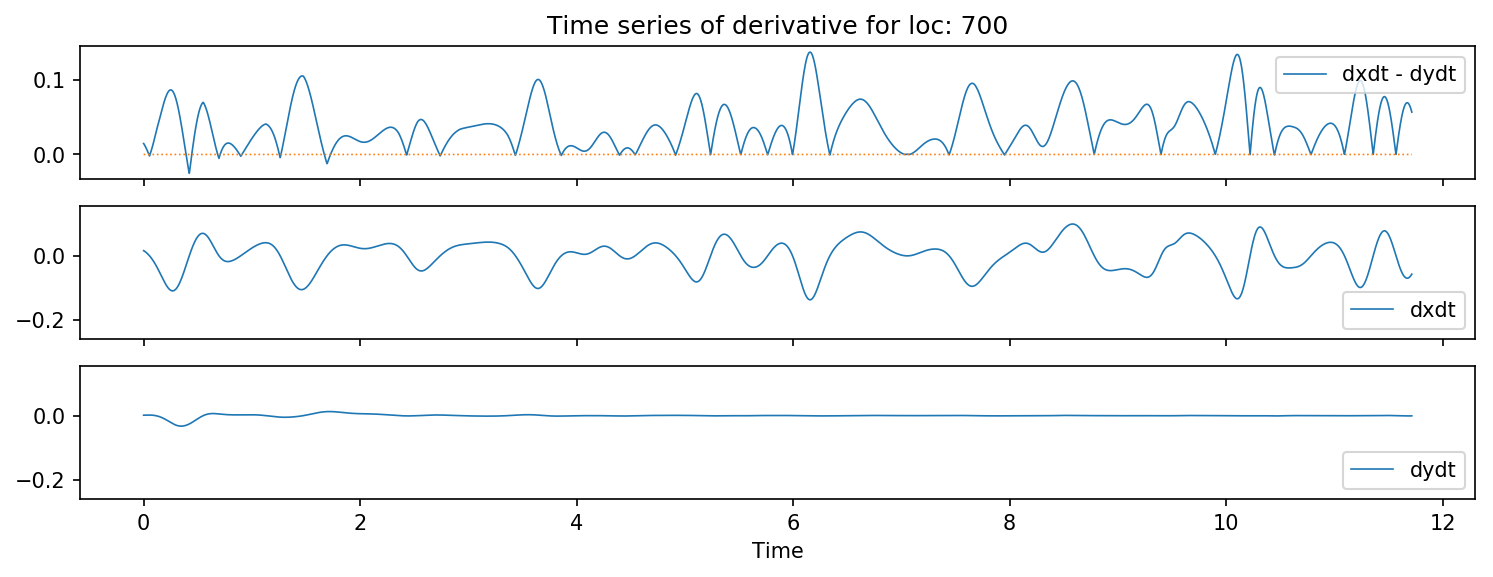

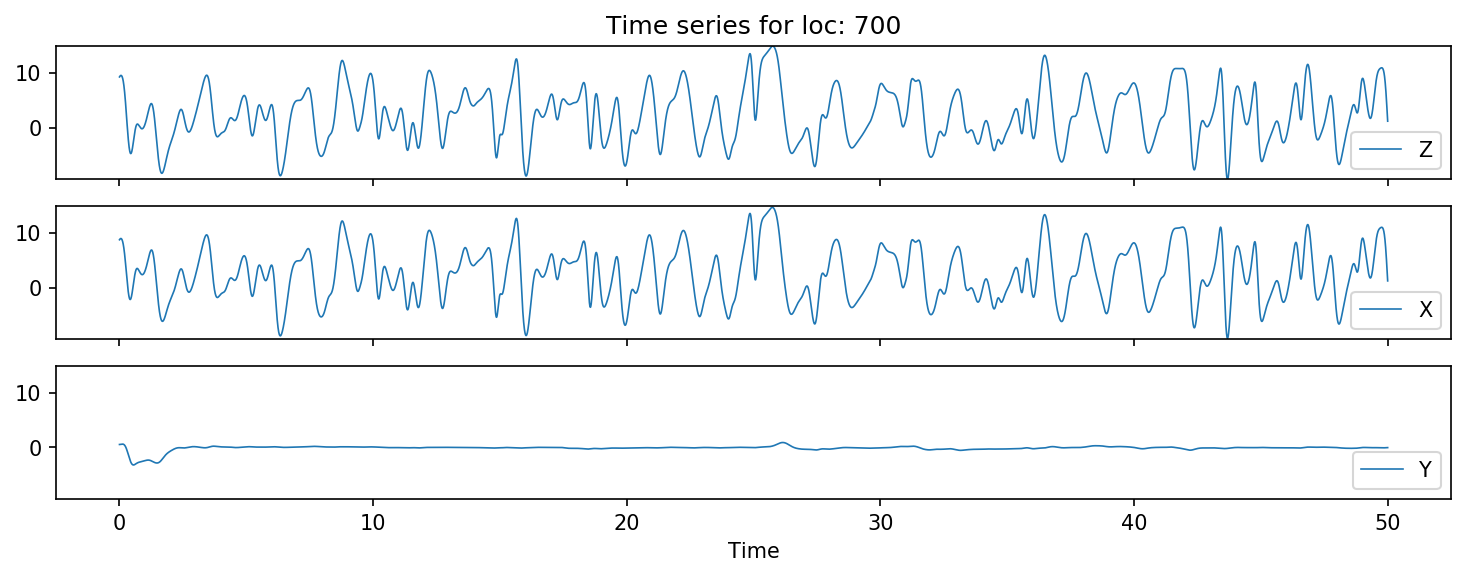

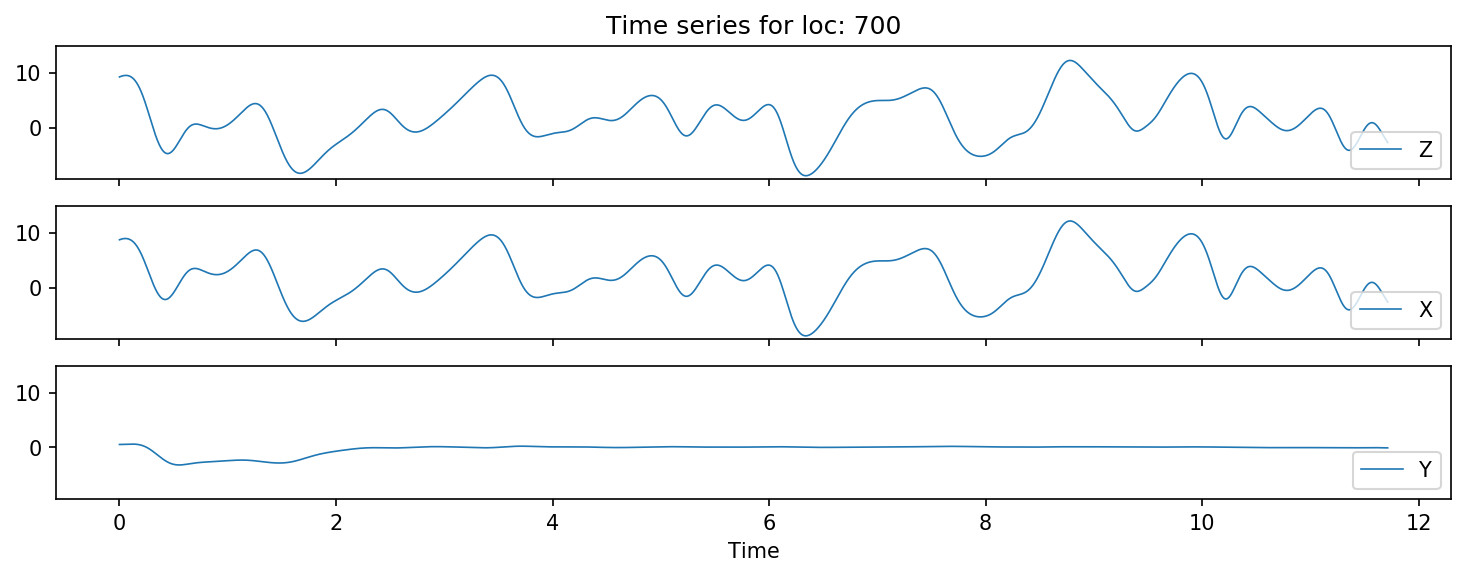

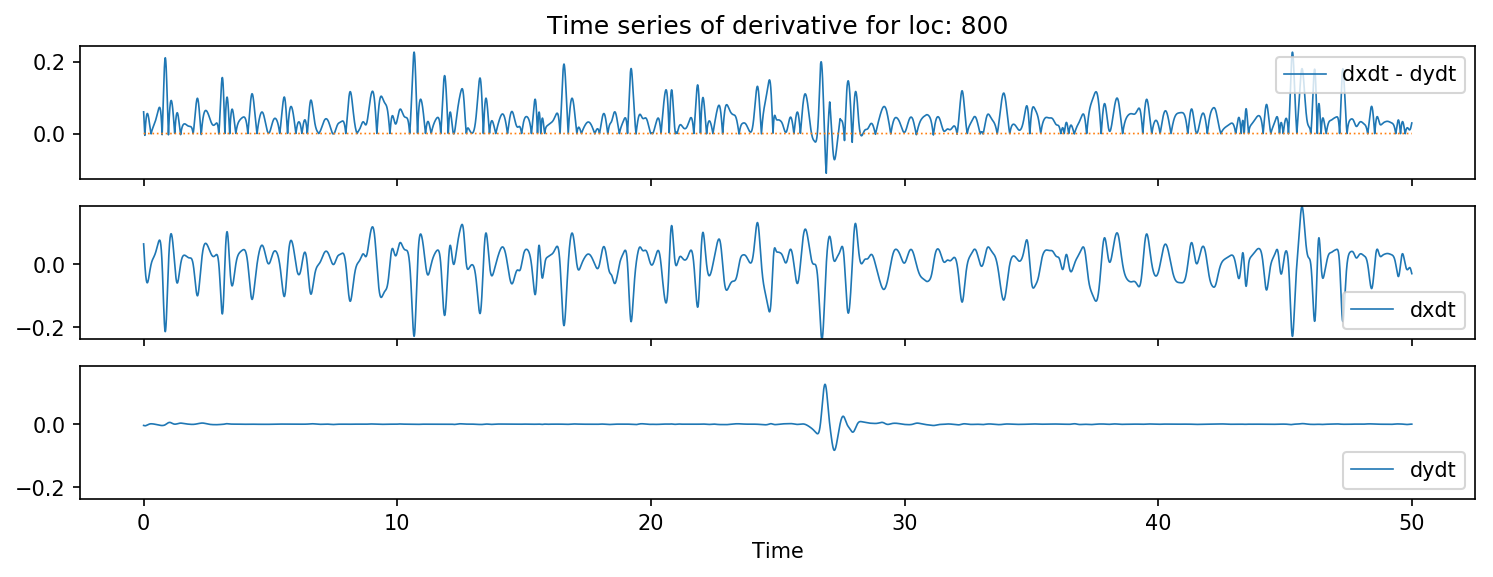

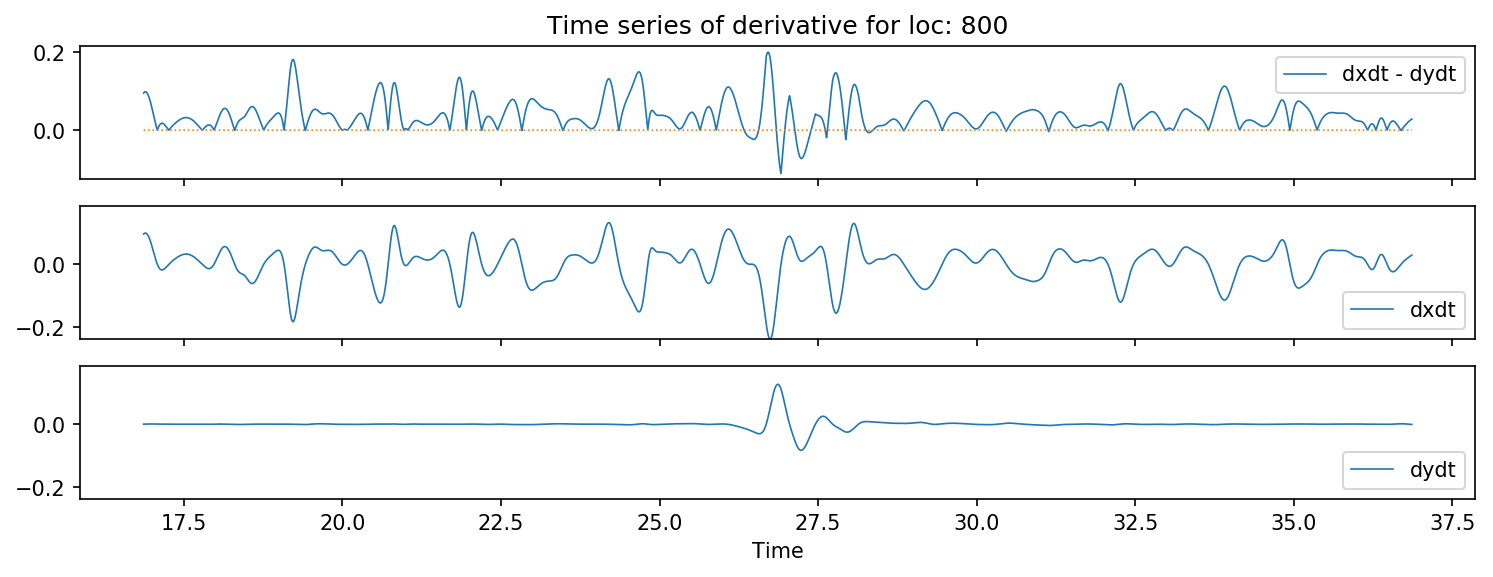

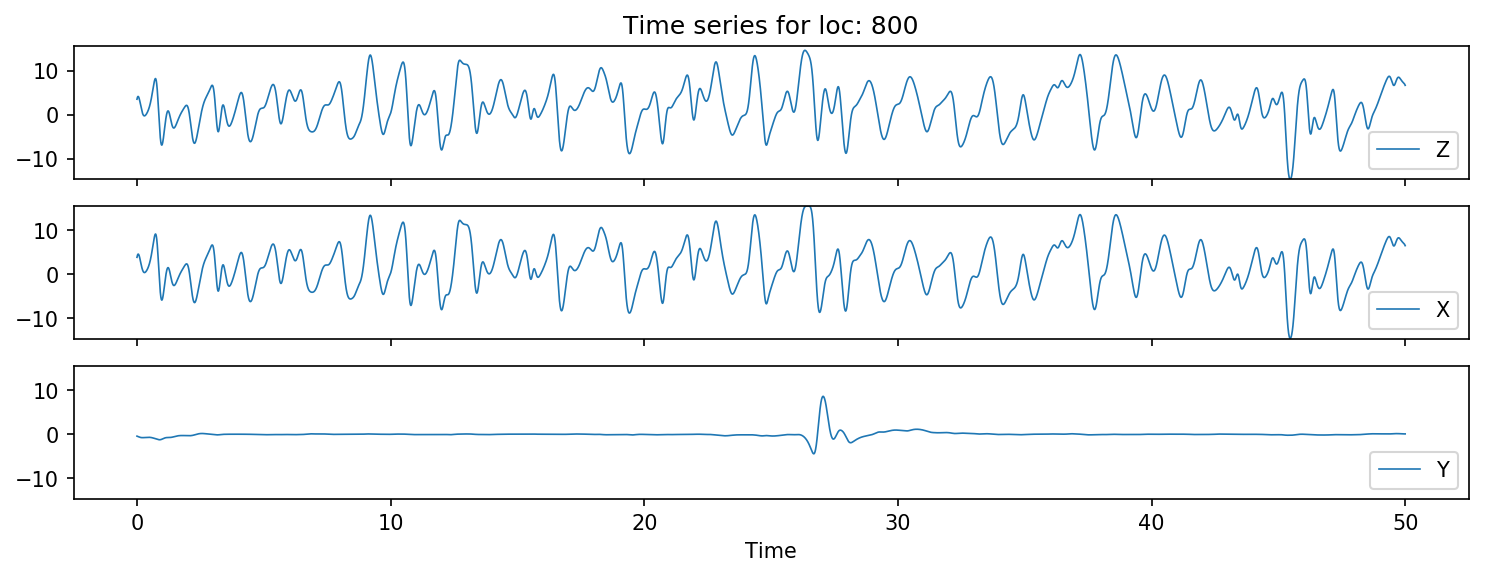

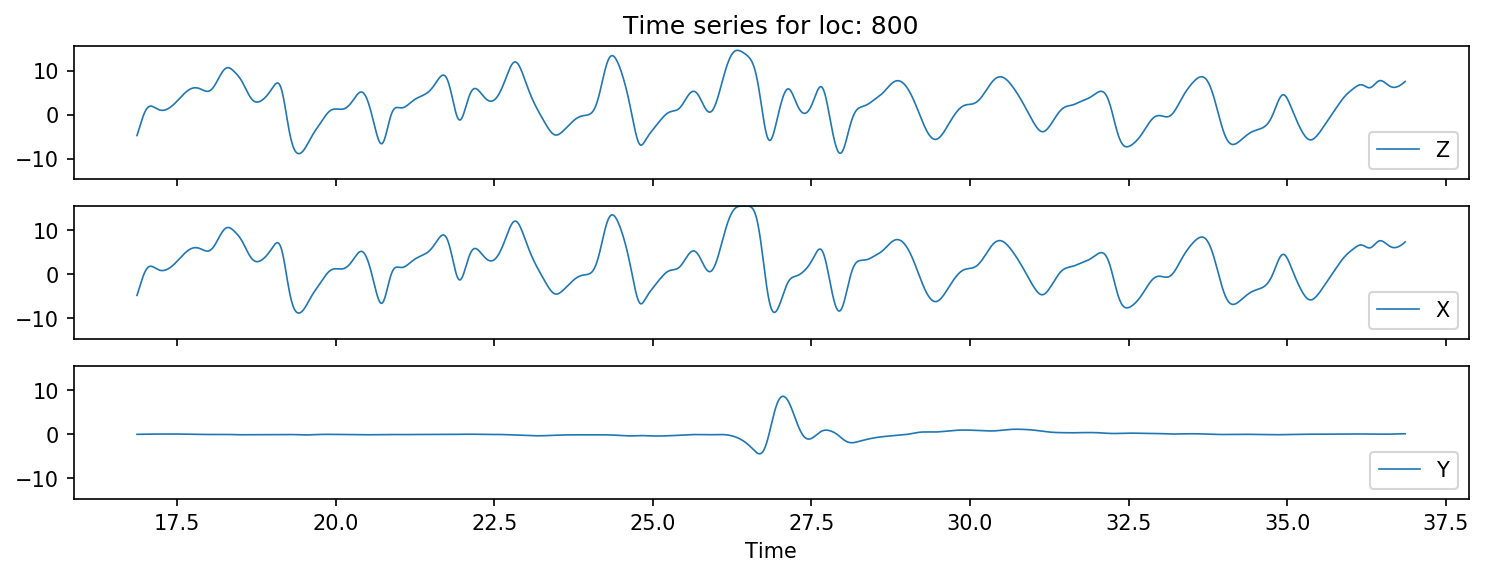

In [69]:
figsize = plt.figaspect(1/3)
dpi = 150
Tmax = 50
plot_t = Zgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax)).time
linewidth = 0.8
window_size = None
zoom_window = int(10/(0.05/24))
for this_loc in range(9):
    this_loc *= 100
    this_Z = Zgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax))
    this_X = Xgt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax))
    this_Y = Ygt_ts.sel(loc=this_loc).sel(time=slice(0, Tmax))
    dzdt = np.gradient(this_Z)
    dxdt = np.gradient(this_X)
    dydt = np.gradient(this_Y)
    if window_size is not None:
        dzdt = ndimage.uniform_filter1d(dzdt, window_size)
        dxdt = ndimage.uniform_filter1d(dxdt, window_size)
        dydt = ndimage.uniform_filter1d(dydt, window_size)
    y_max = np.max([dzdt.max(), dxdt.max(), dydt.max()])
    y_min = np.min([dzdt.min(), dxdt.min(), dydt.min()])
    y_range = [y_min, y_max]
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=figsize, dpi=dpi)
    ax[0].plot(plot_t,
               np.abs(dxdt) - np.abs(dydt),
               linewidth=linewidth)
    ax[0].plot(plot_t,
               np.zeros_like(plot_t),
               ':',
               linewidth=linewidth)
    ax[0].legend(['dxdt - dydt'], loc='upper right')
    ax[0].set_title(f'Time series of derivative for loc: {this_loc}')
#     ax[0].set_ylim(y_range)
    ax[1].plot(plot_t,
               dxdt,
               linewidth=linewidth)
    ax[1].set_ylim(y_range)
    ax[1].legend(['dxdt'], loc='lower right')
    ax[2].plot(plot_t,
               dydt,
               linewidth=linewidth)
    ax[2].set_ylim(y_range)
    ax[2].legend(['dydt'], loc='lower right')
    ax[2].set_xlabel('Time')
    
    this_index = np.argmax(dydt)
    min_index = np.max([0, this_index - zoom_window])
    max_index = np.min([plot_t.size, this_index + zoom_window])
    this_slice = slice(min_index, max_index)
    
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=figsize, dpi=dpi)
#     ax[0].plot(plot_t[this_slice],
#                Zgt_ts.sel(loc=this_loc).isel(time=this_slice),
#                linewidth=linewidth)
    ax[0].plot(plot_t[this_slice],
               (np.abs(dxdt) - np.abs(dydt))[this_slice],
               linewidth=linewidth)
    ax[0].plot(plot_t[this_slice],
               np.zeros_like(plot_t)[this_slice],
               ':',
               linewidth=linewidth)
#     ax[0].set_ylim(y_range)
    ax[0].legend(['dxdt - dydt'], loc='upper right')
    ax[0].set_title(f'Time series of derivative for loc: {this_loc}')
    ax[1].plot(plot_t[this_slice],
               dxdt[this_slice],
               linewidth=linewidth)
    ax[1].set_ylim(y_range)
    ax[1].legend(['dxdt'], loc='lower right')
    ax[2].plot(plot_t[this_slice],
               dydt[this_slice],
               linewidth=linewidth)
    ax[2].set_ylim(y_range)
    ax[2].legend(['dydt'], loc='lower right')
    ax[2].set_xlabel('Time')
    
    
    y_max = np.max([this_Z.max(), this_X.max(), this_Y.max()])
    y_min = np.min([this_Z.min(), this_X.min(), this_Y.min()])
    y_range = [y_min, y_max]
    
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=figsize, dpi=dpi)
    ax[0].plot(plot_t,
               this_Z,
               linewidth=linewidth)
    ax[0].set_ylim(y_range)
    ax[0].legend(['Z'], loc='lower right')
    ax[0].set_title(f'Time series for loc: {this_loc}')
    ax[1].plot(plot_t,
               this_X,
               linewidth=linewidth)
    ax[1].set_ylim(y_range)
    ax[1].legend(['X'], loc='lower right')
    ax[2].plot(plot_t,
               this_Y,
               linewidth=linewidth)
    ax[2].set_ylim(y_range)
    ax[2].legend(['Y'], loc='lower right')
    ax[2].set_xlabel('Time')
    
    
    
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=figsize, dpi=dpi)
    ax[0].plot(plot_t[this_slice],
               this_Z[this_slice],
               linewidth=linewidth)
    ax[0].set_ylim(y_range)
    ax[0].legend(['Z'], loc='lower right')
    ax[0].set_title(f'Time series for loc: {this_loc}')
    ax[1].plot(plot_t[this_slice],
               this_X[this_slice],
               linewidth=linewidth)
    ax[1].set_ylim(y_range)
    ax[1].legend(['X'], loc='lower right')
    ax[2].plot(plot_t[this_slice],
               this_Y[this_slice],
               linewidth=linewidth)
    ax[2].set_ylim(y_range)
    ax[2].legend(['Y'], loc='lower right')
    ax[2].set_xlabel('Time')

In [ ]:
this_Z.shpa